# 6) Character Interaction Graph 
This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Visualize word collocations as a network graph where nodes are words and edges are bigram co-occurrences.
- Identify hub words (high degree) that co-occur frequently with many other words.
- Filter edges by frequency threshold to focus on strong collocations and reveal phrase structure.

In [2]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# --- Standard Config (for file paths) ---
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
}

# Unicode-aware token regex
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# --- New Character Config ---
# Defines the "nodes" of our graph.
# Add or remove names as you see fit.
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took", "peregrin"],
    "Merry": ["merry", "meriadoc", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord", "lord of the rings"],
    "Theoden": ["theoden", "king"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Elrond": ["elrond"],
    "Galadriel": ["galadriel", "lady"],
    "Treebeard": ["treebeard", "fangorn"],
    "Denethor": ["denethor"],
}

print("Cell 1: Config loaded.")

Cell 1: Config loaded.


In [3]:
# ===== Text Loading & Helper Functions =====

# --- Robust Project Gutenberg boilerplate stripper (from Note) ---
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
]
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
]

def strip_gutenberg(text: str) -> str:
    """Heuristically strips Gutenberg headers/footers."""
    t = text.replace("\ufeff", "")  # strip BOM
    start_idx, end_idx = None, None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1: start_idx = m.end()
            break
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else: # Fallback
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m: core = core[m.start():]
            break
    return core.strip()

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    t = strip_gutenberg(t)
    t = t.replace("’", "'") # Normalize apostrophes
    t = t.replace("‘", "'")
    t = re.sub(r"-\s*\n", "", t) # Join hyphenated line breaks
    t = re.sub(r"\s+", " ", t) # Normalize whitespace
    return t

# --- Load and Tokenize All Three Books ---
print("Loading and normalizing texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())
tokens3 = WORD_RE.findall(text3.lower())

print(f"Book 1 (Fellowship) tokens: {len(tokens1):,}")
print(f"Book 2 (Towers) tokens: {len(tokens2):,}")
print(f"Book 3 (Return) tokens: {len(tokens3):,}")

# --- Build the Alias-to-Character Lookup Map ---
# This is a crucial step.
# We create a dictionary that maps "frodo" -> "Frodo", "strider" -> "Aragorn", etc.
# This way, all variations count towards the same character node.

char_alias_map = {}
for main_name, alias_list in CHARACTERS.items():
    for alias in alias_list:
        # Handle multi-word aliases like "dark lord"
        if " " in alias:
            # We'll handle this in the token normalization step
            pass
        else:
            char_alias_map[alias] = main_name

print(f"\nCreated lookup map for {len(char_alias_map)} aliases.")
print("Cell 2: Texts loaded and tokenized.")

Loading and normalizing texts...
Book 1 (Fellowship) tokens: 187,201
Book 2 (Towers) tokens: 153,824
Book 3 (Return) tokens: 135,180

Created lookup map for 33 aliases.
Cell 2: Texts loaded and tokenized.


In [4]:
import itertools
from collections import defaultdict

def build_character_edges(token_list, char_alias_map, main_char_names, window_size=50):
    """
    Slides a window over a token list to find character co-occurrences.
    
    Returns:
        A dictionary of edges, e.g. {('Frodo', 'Sam'): 250, ('Gimli', 'Legolas'): 100}
    """
    
    # This list will hold the main character name for each token, or None
    # e.g. [None, None, 'Frodo', None, 'Aragorn', None, ...]
    normalized_tokens = [char_alias_map.get(token) for token in token_list]
    
    edges = defaultdict(int)
    
    # Slide the window over the normalized token list
    for i in range(len(normalized_tokens) - window_size):
        window = normalized_tokens[i : i + window_size]
        
        # Find all *unique* characters present in this window
        # We use a set to avoid double-counting (e.g., if "Frodo" is said 3 times)
        chars_in_window = set(token for token in window if token is not None)
        
        # If there are 2 or more different characters, they are interacting.
        if len(chars_in_window) >= 2:
            # Create all unique pairs, e.g. (Frodo, Sam), (Frodo, Gandalf), (Sam, Gandalf)
            # We sort the pair to make sure ('Frodo', 'Sam') and ('Sam', 'Frodo') count as the same edge.
            for char_a, char_b in itertools.combinations(sorted(list(chars_in_window)), 2):
                edges[(char_a, char_b)] += 1
                
    return edges

# Get the set of main names, e.g. {'Frodo', 'Sam', 'Gandalf', ...}
main_characters = set(CHARACTERS.keys())

# --- Run the analysis for each book ---
print("Building character networks (this may take a moment)...")

print("Processing Book 1: Fellowship...")
edges_book1 = build_character_edges(tokens1, char_alias_map, main_characters)
print("Processing Book 2: Towers...")
edges_book2 = build_character_edges(tokens2, char_alias_map, main_characters)
print("Processing Book 3: Return...")
edges_book3 = build_character_edges(tokens3, char_alias_map, main_characters)

print("\nAnalysis complete.")

# --- Show a quick preview of the results ---
def print_top_edges(edge_data, book_name, top_n=5):
    if not edge_data:
        print(f"\nNo edges found for {book_name}.")
        return
    
    print(f"\n--- Top {top_n} Interactions in {book_name} ---")
    # Sort the edges by weight (descending)
    sorted_edges = sorted(edge_data.items(), key=lambda item: item[1], reverse=True)
    for (char_a, char_b), weight in sorted_edges[:top_n]:
        print(f"  {char_a} <-> {char_b}: {weight} co-occurrences")

print_top_edges(edges_book1, "Book 1 (Fellowship)")
print_top_edges(edges_book2, "Book 2 (Towers)")
print_top_edges(edges_book3, "Book 3 (Return)")

Building character networks (this may take a moment)...
Processing Book 1: Fellowship...
Processing Book 2: Towers...
Processing Book 3: Return...

Analysis complete.

--- Top 5 Interactions in Book 1 (Fellowship) ---
  Frodo <-> Sam: 7723 co-occurrences
  Frodo <-> Gandalf: 6635 co-occurrences
  Aragorn <-> Frodo: 5787 co-occurrences
  Frodo <-> Pippin: 5643 co-occurrences
  Frodo <-> Merry: 3899 co-occurrences

--- Top 5 Interactions in Book 2 (Towers) ---
  Frodo <-> Sam: 7643 co-occurrences
  Gollum <-> Sam: 4585 co-occurrences
  Frodo <-> Gollum: 4251 co-occurrences
  Gimli <-> Legolas: 3091 co-occurrences
  Merry <-> Pippin: 2902 co-occurrences

--- Top 5 Interactions in Book 3 (Return) ---
  Frodo <-> Sam: 8842 co-occurrences
  Gandalf <-> Pippin: 3815 co-occurrences
  Merry <-> Pippin: 2515 co-occurrences
  Frodo <-> Pippin: 2068 co-occurrences
  Denethor <-> Gandalf: 1759 co-occurrences


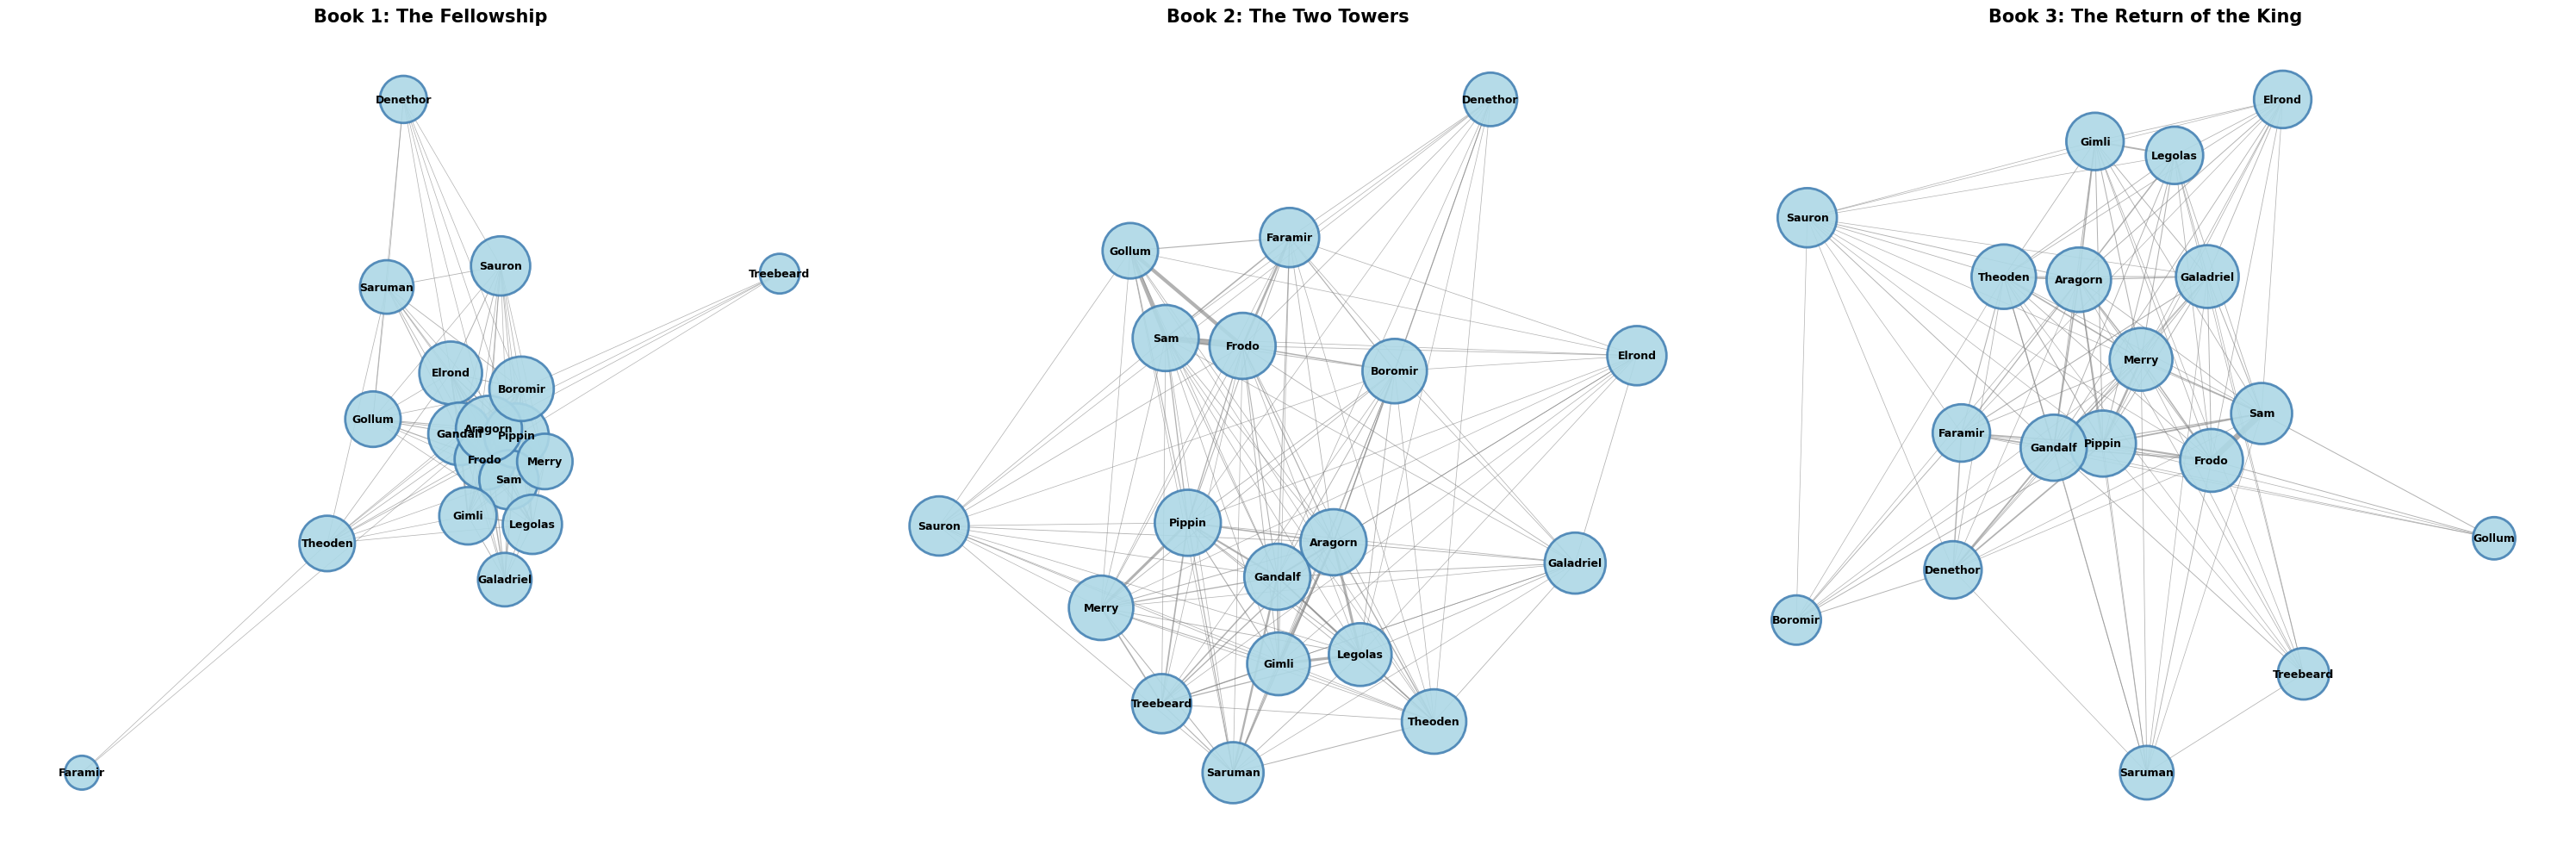

Saved graph to ../results/character_networks.png


In [5]:
import numpy as np

def draw_character_network(ax, edge_data, book_title):
    """
    Draws a character network graph on a given matplotlib axis.
    """
    
  # 1. Create the graph from our edge data
    G = nx.Graph()
    for (char_a, char_b), weight in edge_data.items():
        if weight > 0:
            G.add_edge(char_a, char_b, weight=weight)
            
    if not G.nodes():
        ax.set_title(f"{book_title}\n(No character interactions found)")
        ax.axis('off')
        return

    # 2. Calculate layout
    # === FINAL FIX: Aggressively increased 'k' and 'iterations' ===
    # k controls the optimal distance between nodes. Higher = more spread.
    # iterations gives the algorithm more time to find a good layout.
    pos = nx.spring_layout(G, k=0.9, iterations=100, seed=42, weight='weight')

    # 3. Get node and edge attributes for drawing
    
    # Node size: based on "degree"
    degrees = dict(G.degree())
    node_sizes = [degrees.get(node, 0) * 150 + 500 for node in G.nodes()]
    
    # Edge width: based on "weight"
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    if weights:
        min_w, max_w = min(weights), max(weights)
        norm_weights = [(w - min_w) / (max_w - min_w + 1e-6) for w in weights]
        edge_widths = [0.5 + 4.5 * w for w in norm_weights]
    else:
        edge_widths = [1] * len(G.edges())

    # 4. Draw the graph
    nx.draw_networkx_nodes(
        G, pos,
        ax=ax,
        node_size=node_sizes,
        node_color='lightblue',
        edgecolors='steelblue',
        alpha=0.9,
        linewidths=2
    )
    
    nx.draw_networkx_edges(
        G, pos,
        ax=ax,
        width=edge_widths,
        edge_color='gray',
        alpha=0.6
    )
    
    nx.draw_networkx_labels(
        G, pos,
        ax=ax,
        font_size=9, # Keep font small
        font_weight='bold'
    )
    
    ax.set_title(book_title, fontsize=15, fontweight='bold')
    ax.axis('off')

# --- Create the 1x3 Plot Grid ---
# === FINAL FIX: Made figure even wider ===
fig, axes = plt.subplots(1, 3, figsize=(30, 10)) 

draw_character_network(axes[0], edges_book1, "Book 1: The Fellowship")
draw_character_network(axes[1], edges_book2, "Book 2: The Two Towers")
draw_character_network(axes[2], edges_book3, "Book 3: The Return of the King")

plt.tight_layout()
plt.show()

# Save the final figure
fig.savefig("../results/character_networks.png", dpi=200, bbox_inches="tight")
print("Saved graph to ../results/character_networks.png")

In [6]:
# --- This is a new, simpler Cell 5. ---
# It replaces the complex dialogue-finding code.
#
# This code builds a DIRECTED graph based on a simple rule:
# "When characters are mentioned, the first one mentioned is the 'speaker',
# and all others mentioned soon after are the 'addressees'."

from collections import defaultdict, Counter
import itertools

def find_simple_directed_edges(token_list, char_alias_map, window_size=25):
    """
    Finds directed Speaker -> Addressee interactions based on proximity.
    
    Returns a dict:
    { ("Speaker", "Addressee"): weight }
    """
    
    # This will store all directed pairs and their counts
    directed_edges = defaultdict(int)
    
    # Create the list of normalized character tokens (e.g., [None, 'Frodo', None, 'Sam'])
    normalized_tokens = [char_alias_map.get(token) for token in token_list]
    
    # Slide the window over the normalized token list
    for i in range(len(normalized_tokens) - window_size):
        window = normalized_tokens[i : i + window_size]
        
        # Find all characters in the window, *preserving order* and *uniqueness*
        chars_in_window = []
        seen = set()
        for token in window:
            if token is not None and token not in seen:
                chars_in_window.append(token)
                seen.add(token)
                
        # If there are 2 or more characters...
        if len(chars_in_window) >= 2:
            # The *first* one is the "speaker" for this window
            speaker = chars_in_window[0]
            
            # All *other* characters are the "addressees"
            for addressee in chars_in_window[1:]:
                directed_edges[(speaker, addressee)] += 1
                
    return directed_edges

# --- Run the New Analysis ---
print("Building simple DIRECTED character networks...")

print("Processing Book 1: Fellowship...")
# We now get a simple dictionary of counts, e.g. {('Frodo', 'Sam'): 1234}
directed_edges_b1_counts = find_simple_directed_edges(tokens1, char_alias_map)
print("Processing Book 2: Towers...")
directed_edges_b2_counts = find_simple_directed_edges(tokens2, char_alias_map)
print("Processing Book 3: Return...")
directed_edges_b3_counts = find_simple_directed_edges(tokens3, char_alias_map)

print("\nAnalysis complete.")

# --- Show a quick preview (Book 1) ---
print("\n--- Top Directed Interactions (Book 1) ---")
sorted_interactions = sorted(directed_edges_b1_counts.items(), key=lambda item: item[1], reverse=True)
for (speaker, addressee), count in sorted_interactions[:10]:
    print(f'  {speaker} -> {addressee} (count: {count})')

Building simple DIRECTED character networks...
Processing Book 1: Fellowship...
Processing Book 2: Towers...
Processing Book 3: Return...

Analysis complete.

--- Top Directed Interactions (Book 1) ---
  Frodo -> Sam (count: 1477)
  Frodo -> Gandalf (count: 1020)
  Sam -> Frodo (count: 953)
  Aragorn -> Frodo (count: 793)
  Frodo -> Pippin (count: 773)
  Gandalf -> Frodo (count: 758)
  Frodo -> Aragorn (count: 723)
  Pippin -> Frodo (count: 663)
  Merry -> Pippin (count: 557)
  Frodo -> Merry (count: 542)


In [7]:
# --- This cell builds the DIRECTED graph from Cell 5's data ---

# 1. Create a Directed Graph object
G_directed = nx.DiGraph()

# 2. Filter the data for a cleaner graph
# Get the top 25 strongest directed edges from Book 1
sorted_interactions = sorted(directed_edges_b1_counts.items(), key=lambda item: item[1], reverse=True)
top_edges = dict(sorted_interactions[:31])

all_nodes = set()
edge_labels = {}

for (speaker, addressee), count in top_edges.items():
    G_directed.add_edge(speaker, addressee, weight=count)
    edge_labels[(speaker, addressee)] = f' (x{count})' # Just show the count
    all_nodes.add(speaker)
    all_nodes.add(addressee)

# 3. Create a new figure and axis
fig_directed, ax_directed = plt.subplots(figsize=(16, 12))

# 4. Check if the graph is empty
if not G_directed.nodes():
    print("--- ERROR: No directed edges were found. ---")
else:
    # 5. Calculate layout
    G_directed.add_nodes_from(all_nodes)
    pos = nx.spring_layout(G_directed, k=0.9, iterations=100, seed=42)

    # 6. Draw Nodes
    node_sizes = [len(n) * 300 for n in G_directed.nodes()] 
    nx.draw_networkx_nodes(
        G_directed, pos,
        ax=ax_directed,
        node_size=node_sizes,
        node_color='lightblue',
        edgecolors='steelblue',
        alpha=0.9,
        linewidths=2
    )

    # 7. Draw Edges
    nx.draw_networkx_edges(
        G_directed, pos,
        ax=ax_directed,
        node_size=node_sizes,
        arrowstyle='->',
        arrowsize=20,
        edge_color='gray',
        alpha=0.6,
        width=2,
        connectionstyle='arc3,rad=0.1' 
    )

    # 8. Draw Node Labels (the names)
    nx.draw_networkx_labels(
        G_directed, pos,
        ax=ax_directed,
        font_size=12,
        font_weight='bold'
    )

    # 9. Draw Edge Labels (the counts)
    nx.draw_networkx_edge_labels(
        G_directed, pos,
        edge_labels=edge_labels,
        font_color='black',
        font_size=9,
        font_weight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    ax_directed.set_title(f"Book 1: Top 31 Directed Interactions (Heuristic)", fontsize=15, fontweight='bold')
    ax_directed.axis('off')
    plt.tight_layout()
    plt.show()

    fig_directed.savefig("../results/character_network_directed_simple.png", dpi=200, bbox_inches="tight")
    print("Saved directed graph to ../results/character_network_directed_simple.png")

KeyboardInterrupt: 

Drawing graph for Book 2: The Two Towers...


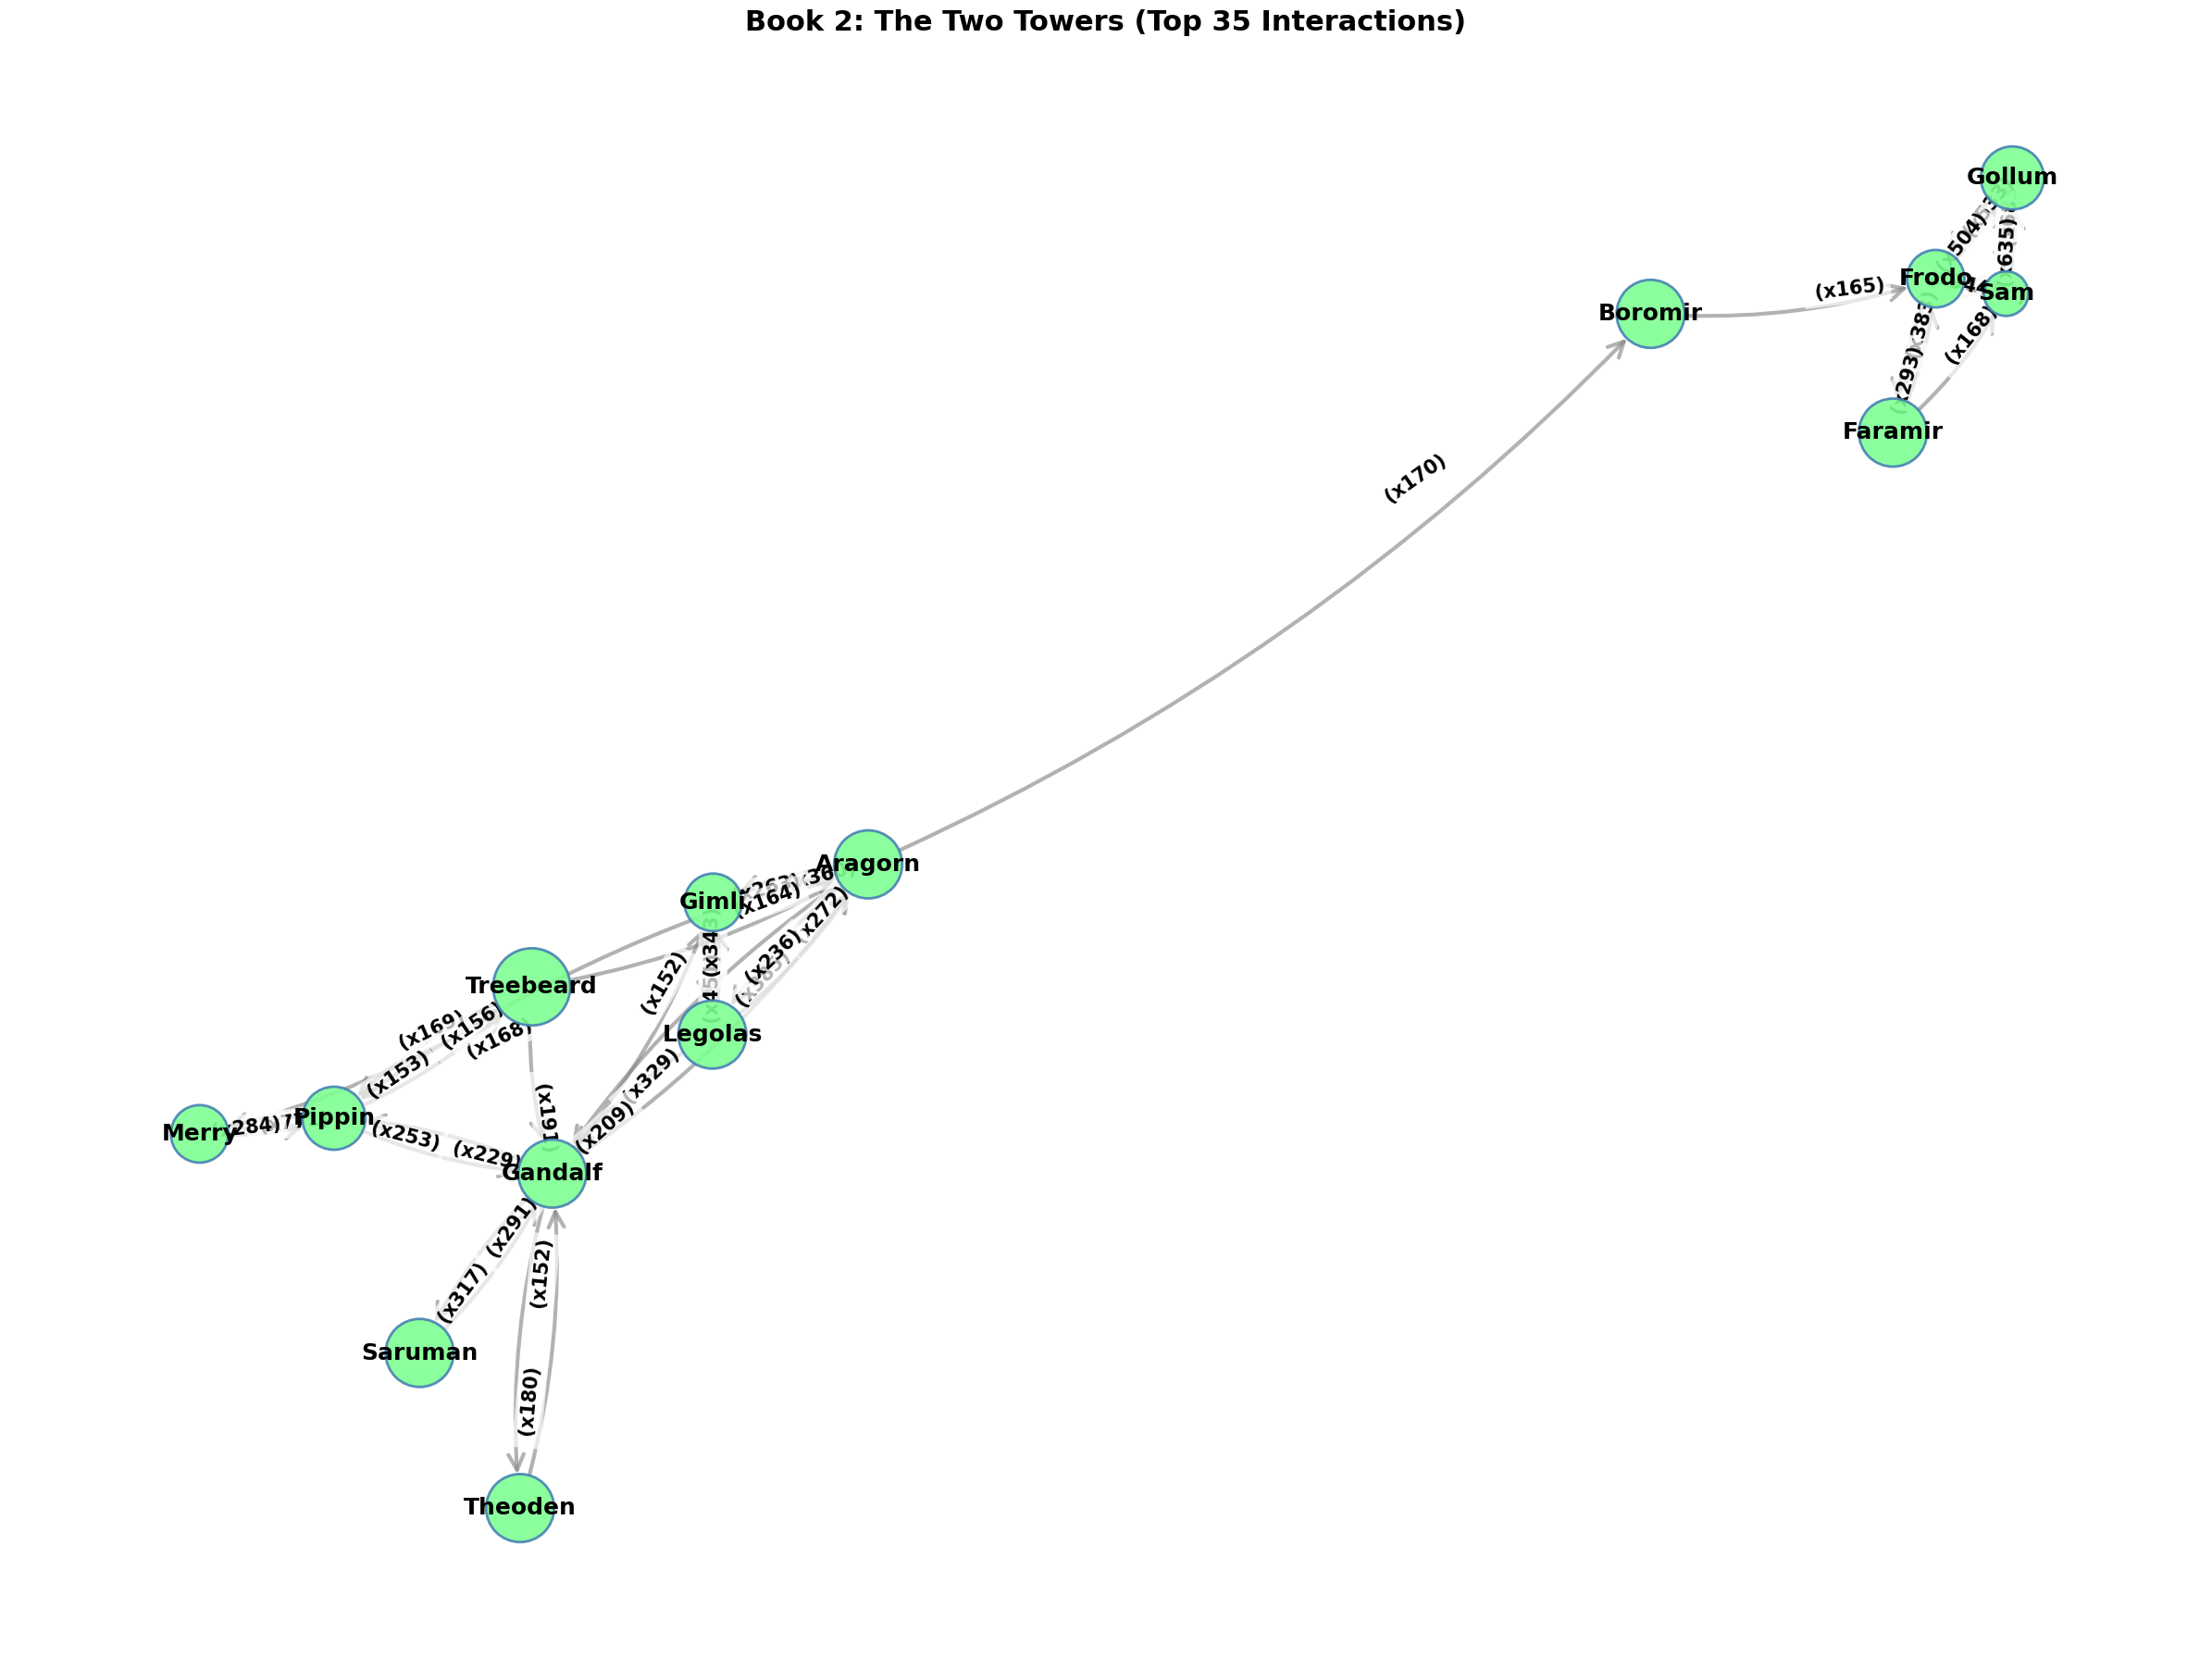

Saved Book 2 graph to ../results/


In [29]:
# --- This cell defines the plotting function and draws Book 2 ---

def draw_simple_directed_graph(ax, directed_edge_counts, book_title, top_n=35):
    """
    Draws a filtered, directed character graph on a given matplotlib axis.
    """
    
    # 1. Create a Directed Graph object
    G_directed = nx.DiGraph()

    # 2. Filter the data for a cleaner graph
    sorted_interactions = sorted(directed_edge_counts.items(), key=lambda item: item[1], reverse=True)
    top_edges = dict(sorted_interactions[:top_n])

    all_nodes = set()
    edge_labels = {}

    for (speaker, addressee), count in top_edges.items():
        G_directed.add_edge(speaker, addressee, weight=count)
        edge_labels[(speaker, addressee)] = f' (x{count})'
        all_nodes.add(speaker)
        all_nodes.add(addressee)

    # 3. Check if the graph is empty
    if not G_directed.nodes():
        ax.set_title(f"{book_title}\n(No strong interactions found)", fontsize=18, fontweight='bold')
        ax.axis('off')
        return

    # 4. Calculate layout
    G_directed.add_nodes_from(all_nodes)
    # === FIX: Increased k to 1.0 for maximum spread ===
    pos = nx.spring_layout(G_directed, k=1.0, iterations=100, seed=42)

    # 5. Draw Nodes
    node_sizes = [len(n) * 400 for n in G_directed.nodes()] # Made nodes bigger
    nx.draw_networkx_nodes(
        G_directed, pos,
        ax=ax,
        node_size=node_sizes,
        # node_color='#FF7F7F',
        node_color="#7FFF92",
        edgecolors='steelblue',
        alpha=0.9,
        linewidths=2
    )

    # 6. Draw Edges
    nx.draw_networkx_edges(
        G_directed, pos,
        ax=ax,
        node_size=node_sizes,
        arrowstyle='->',
        arrowsize=30, # Made arrows bigger
        edge_color='gray',
        alpha=0.6,
        width=3, # Made lines thicker
        connectionstyle='arc3,rad=0.1' 
    )

    # 7. Draw Node Labels (the names)
    # === FIX: Massively increased font size ===
    nx.draw_networkx_labels(
        G_directed, pos,
        ax=ax,
        font_size=18, # Was 14
        font_weight='bold'
    )

    # 8. Draw Edge Labels (the counts)
    # === FIX: Massively increased font size ===
    nx.draw_networkx_edge_labels(
        G_directed, pos,
        edge_labels=edge_labels,
        font_color='black',
        font_size=15, # Was 12
        font_weight='bold',
        label_pos=0.7, 
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    ax.set_title(f"{book_title} (Top {top_n} Interactions)", fontsize=22, fontweight='bold')
    ax.axis('off')

# --- Create the Plot for Book 2 ---
# === FIX: Increased figure size for more space ===
fig_book2, ax_book2 = plt.subplots(figsize=(24, 18)) # Was (20, 15)

print("Drawing graph for Book 2: The Two Towers...")
draw_simple_directed_graph(
    ax_book2,
    directed_edges_b2_counts,
    "Book 2: The Two Towers"
)

plt.tight_layout()
plt.show()

fig_book2.savefig("../results/character_network_directed_book2.png", dpi=200, bbox_inches="tight")
print("Saved Book 2 graph to ../results/")

In [30]:
# --- This cell plots the directed graph for Book 3 ---

# === FIX: Increased figure size for more space ===
fig_book3, ax_book3 = plt.subplots(figsize=(24, 18)) # Was (20, 15)

print("Drawing graph for Book 3: The Return of the King...")
draw_simple_directed_graph(
    ax_book3,
    directed_edges_b3_counts,
    "Book 3: The Return of the King"
)

plt.tight_layout()
plt.show()

fig_book3.savefig("../results/character_network_directed_book3.png", dpi=200, bbox_inches="tight")
print("Saved Book 3 graph to ../results/")

Drawing graph for Book 3: The Return of the King...


Saved Book 3 graph to ../results/


In [33]:
import re
import itertools
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx

# --- Config: Paths & Characters ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas", "greenleaf"],
    "Gimli": ["gimli", "gloin"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took", "peregrin"],
    "Merry": ["merry", "meriadoc", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "enemy", "dark lord"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Elrond": ["elrond"],
    "Galadriel": ["galadriel", "lady of lorien"],
    "Treebeard": ["treebeard", "fangorn"],
    "Denethor": ["denethor"],
    "Bilbo": ["bilbo"],
}

# --- Helper: Map Aliases ---
def create_alias_map(character_dict):
    lookup = {}
    for main_name, aliases in character_dict.items():
        for alias in aliases:
            lookup[alias] = main_name
    return lookup

ALIAS_MAP = create_alias_map(CHARACTERS)

# --- Helper: Text Cleaning ---
def clean_and_tokenize(filepath):
    """Loads a file, cleans headers, and returns a list of lowercase words."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
        
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # 1. Strip Boilerplate (Simple heuristics)
    start_markers = ["*** START", "PROLOGUE", "Chapter 1"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    
    start_idx = 0
    end_idx = len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx
            break
            
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx
            break
            
    text = text[start_idx:end_idx].lower()
    
    # 2. Tokenize (keep words only)
    # This regex splits by whitespace and removes punctuation
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", text)
    return tokens

# --- Load Data ---
print("Loading books...")
tokens_b1 = clean_and_tokenize(CONFIG["book1_path"])
tokens_b2 = clean_and_tokenize(CONFIG["book2_path"])
tokens_b3 = clean_and_tokenize(CONFIG["book3_path"])

print(f"Book 1: {len(tokens_b1):,} tokens")
print(f"Book 2: {len(tokens_b2):,} tokens")
print(f"Book 3: {len(tokens_b3):,} tokens")

Loading books...
Book 1: 179,151 tokens
Book 2: 155,328 tokens
Book 3: 71,437 tokens


In [117]:
def get_directed_interactions(tokens, alias_map, window_size=15):
    """
    Scans the text for character mentions.
    If 'Frodo' appears at word #100 and 'Sam' at word #105, 
    we count a directed edge: Frodo -> Sam.
    """
    
    # 1. Identify where every character appears
    # Returns a list like: [('Frodo', 100), ('Sam', 105), ('Gandalf', 150)...]
    char_appearances = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            char_appearances.append((char_name, i))
            
    # 2. Count interactions based on proximity
    directed_edges = defaultdict(int)
    
    # Loop through every character mention
    for i in range(len(char_appearances)):
        speaker, speaker_pos = char_appearances[i]
        
        # Look ahead at the next few characters
        # We only check subsequent characters that are within 'window_size' words
        for j in range(i + 1, len(char_appearances)):
            target, target_pos = char_appearances[j]
            
            distance = target_pos - speaker_pos
            
            if distance <= window_size:
                if speaker != target:
                    # Found an interaction!
                    directed_edges[(speaker, target)] += 1
            else:
                # If this character is too far, no need to check further 
                # (since the list is sorted by position)
                break
                
    return directed_edges

print("\nCalculating interactions (Corrected Method)...")

# We use a window of 25 words (approx 1-2 sentences)
edges_b1 = get_directed_interactions(tokens_b1, ALIAS_MAP, window_size=15)
edges_b2 = get_directed_interactions(tokens_b2, ALIAS_MAP, window_size=15)
edges_b3 = get_directed_interactions(tokens_b3, ALIAS_MAP, window_size=25)

# Preview
print("Top 5 interactions in Book 1:")
sorted_preview = sorted(edges_b1.items(), key=lambda x: x[1], reverse=True)
for pair, count in sorted_preview[:5]:
    print(f"  {pair[0]} -> {pair[1]}: {count}")


Calculating interactions (Corrected Method)...
Top 5 interactions in Book 1:
  Frodo -> Sam: 94
  Sam -> Frodo: 70
  Frodo -> Gandalf: 61
  Frodo -> Pippin: 53
  Bilbo -> Frodo: 51


Generating visualizations...
Generated graph for: Book 1: The Fellowship of the Ring


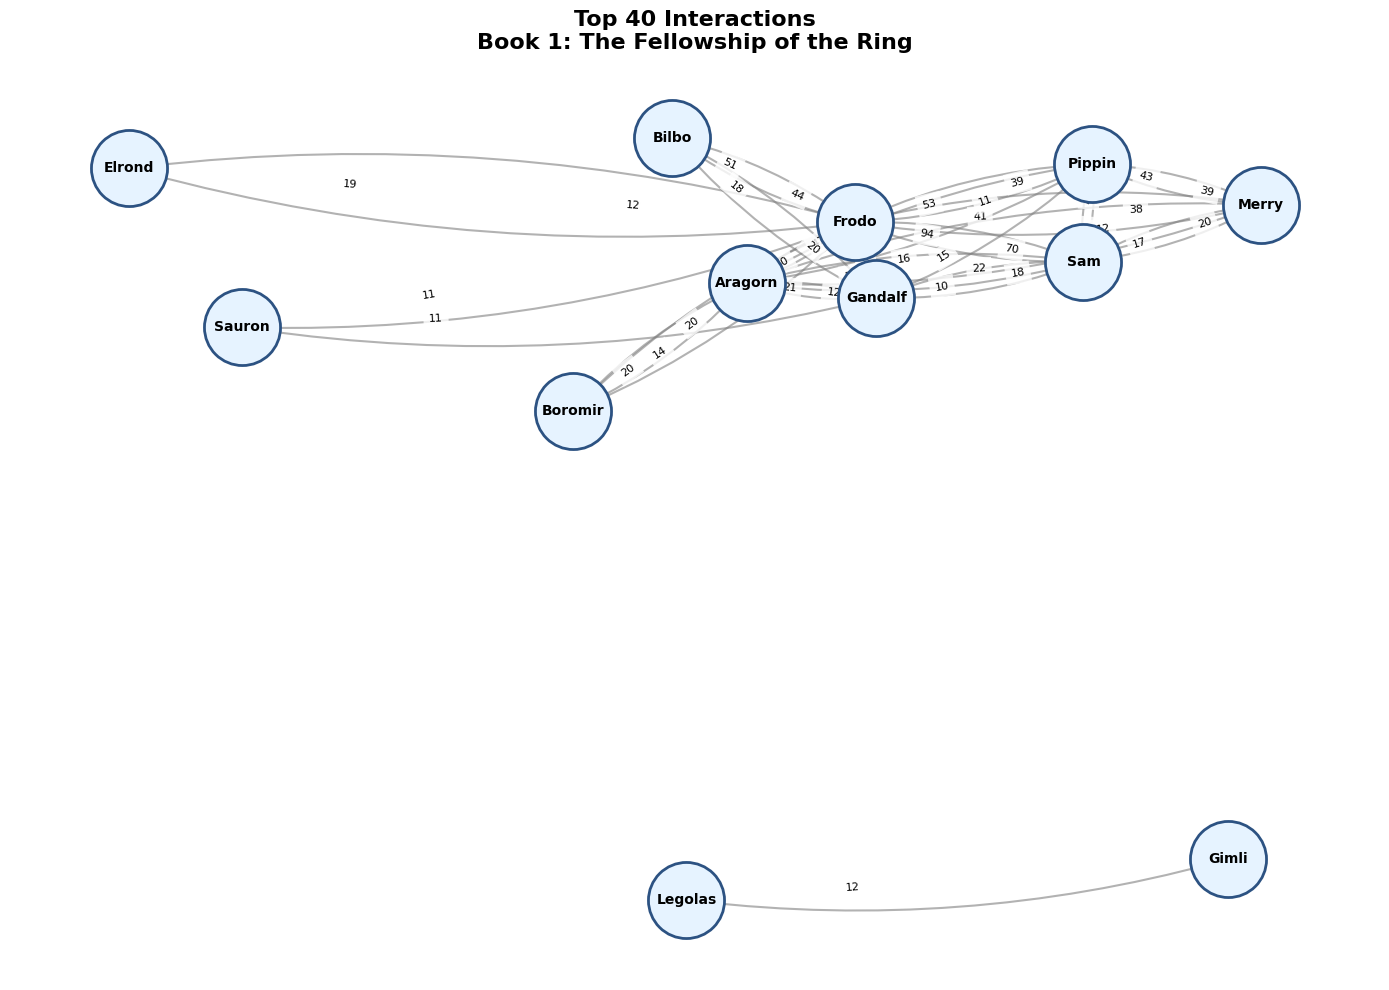

Generated graph for: Book 2: The Two Towers


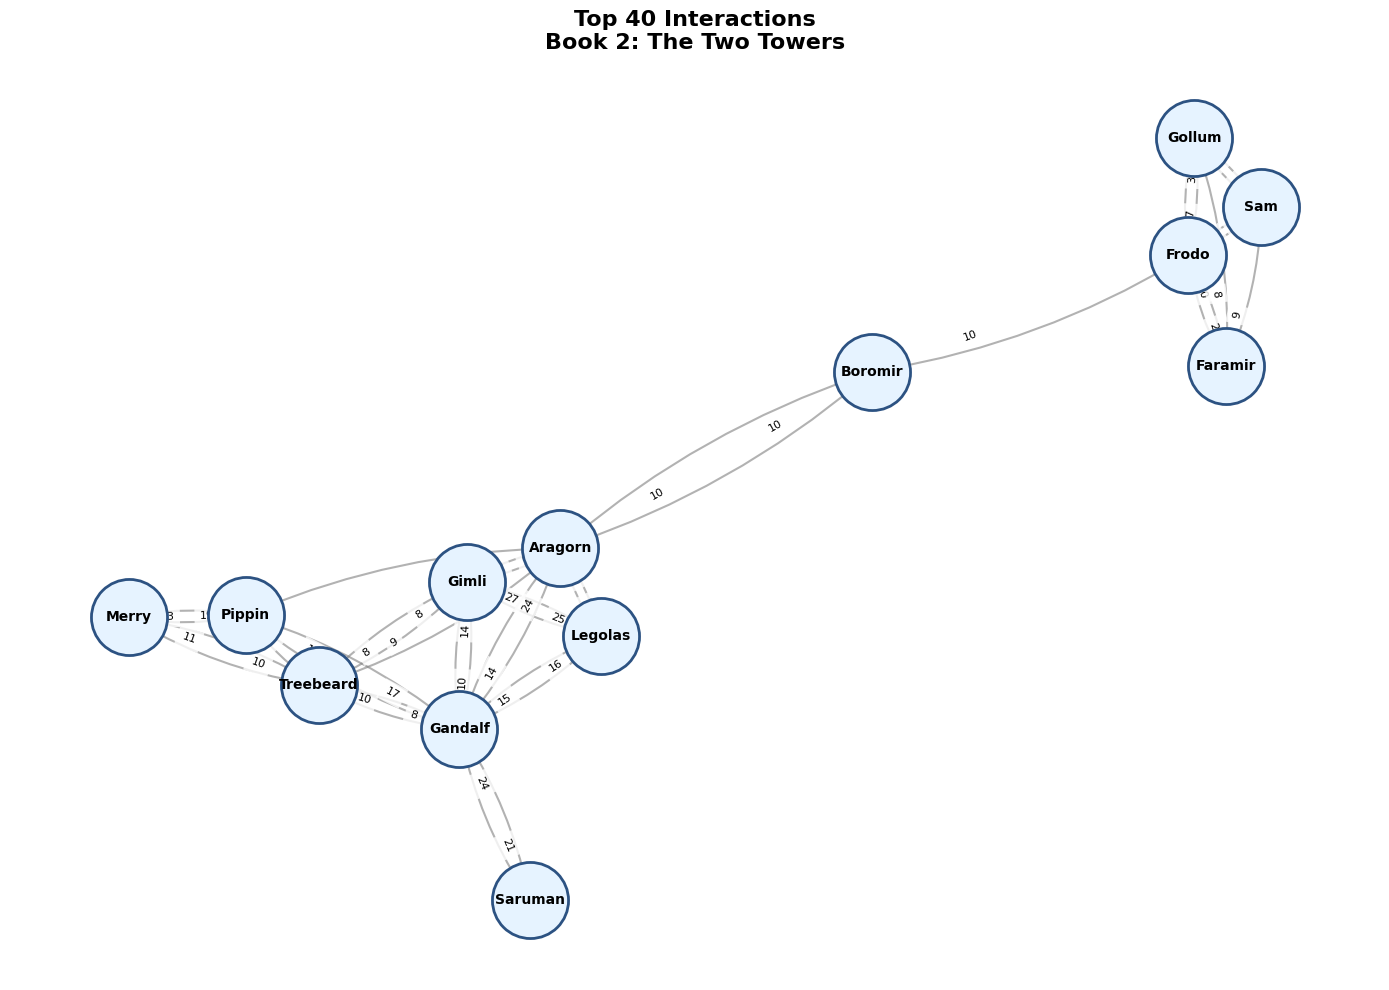

Generated graph for: Book 3: The Return of the King


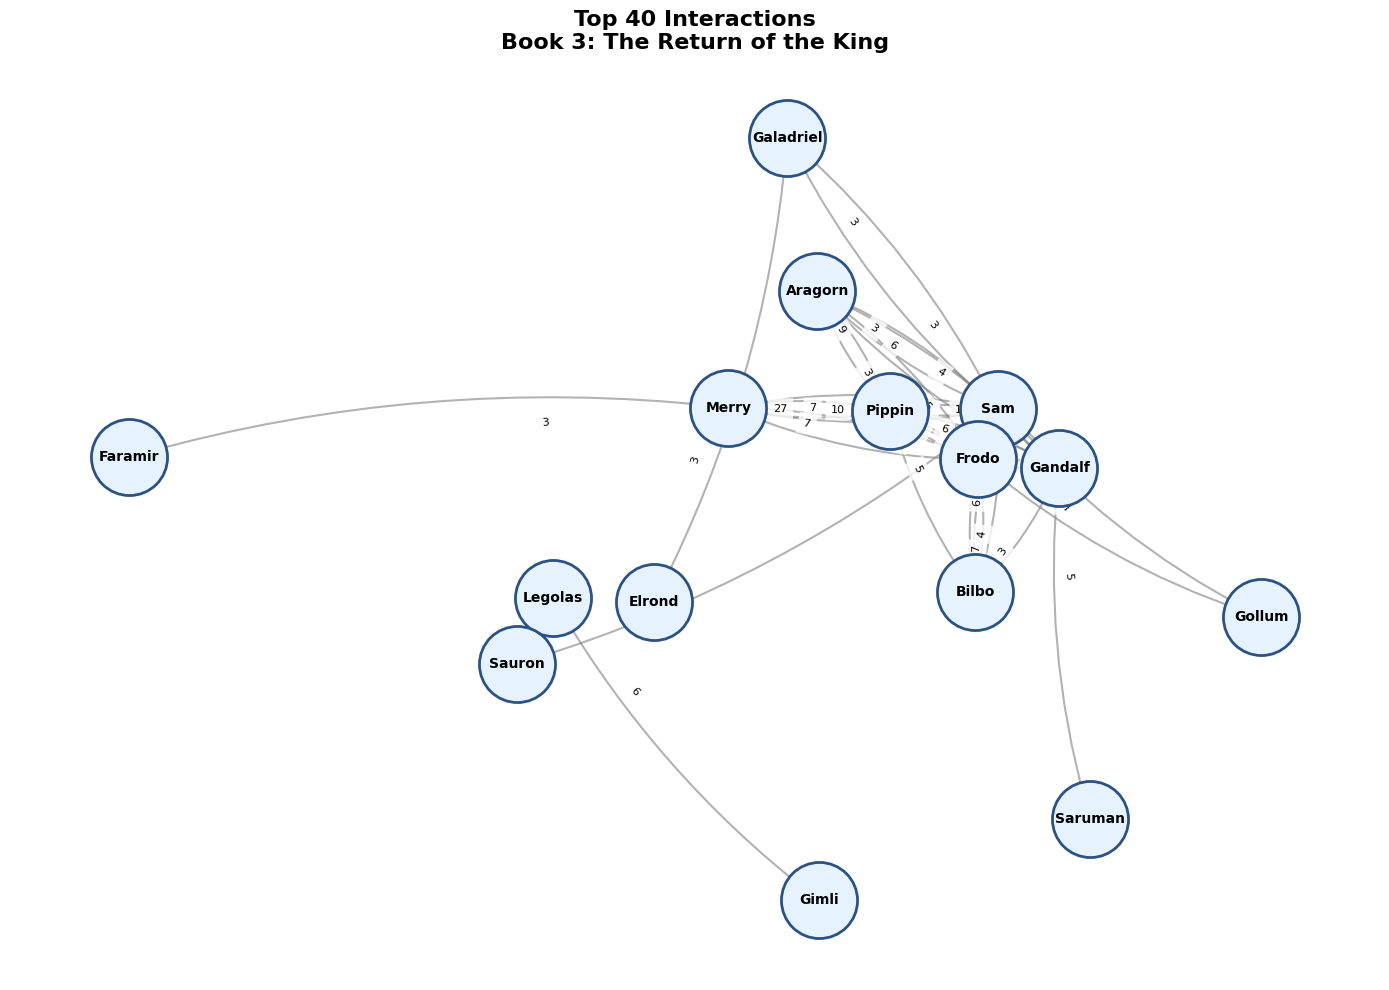

In [58]:
import matplotlib.pyplot as plt
import networkx as nx

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40):
    """
    Generates a directed graph visualization for a given book's interaction data.
    """
    
    # 1. Setup the Graph
    G = nx.DiGraph()
    
    # 2. Filter Top Interactions
    # Sort by weight (count) and take the top N to avoid clutter
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes to the graph
    edge_labels = {}
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)
        edge_labels[(u, v)] = str(weight)

    # 3. Create the Plot
    plt.figure(figsize=(14, 10))
    
    # Layout: Spring layout often works best for social networks
    # k=1.5 increases the distance between nodes
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=3000,
        node_color='#e6f3ff',   # Light blue
        edgecolors='#2c5282',   # Dark blue border
        linewidths=2
    )
    
    # Draw Edges (Curved)
    # connectionstyle='arc3, rad=0.1' creates the curve so A->B and B->A don't overlap
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=20,
        edge_color='gray',
        width=1.5,
        connectionstyle='arc3, rad=0.1',
        alpha=0.6
    )
    
    # Draw Labels (Character Names)
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Interaction Counts)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.3, # Offset slightly from center
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    plt.title(f"Top {top_n} Interactions\n{book_title}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    # 4. Save and Show
    # plt.savefig(filename, dpi=150, bbox_inches="tight") # Uncomment to save locally
    print(f"Generated graph for: {book_title}")
    plt.show()

# --- EXECUTE VISUALIZATION FOR ALL BOOKS ---
# Assumes 'edges_b1', 'edges_b2', and 'edges_b3' exist from the previous Analysis step.

print("Generating visualizations...")

plot_and_save_network(edges_b1, "Book 1: The Fellowship of the Ring", "network_book1.png")
plot_and_save_network(edges_b2, "Book 2: The Two Towers", "network_book2.png")
plot_and_save_network(edges_b3, "Book 3: The Return of the King", "network_book3.png")

Generating visualizations...
Generated graph for: Book 1: The Fellowship of the Ring


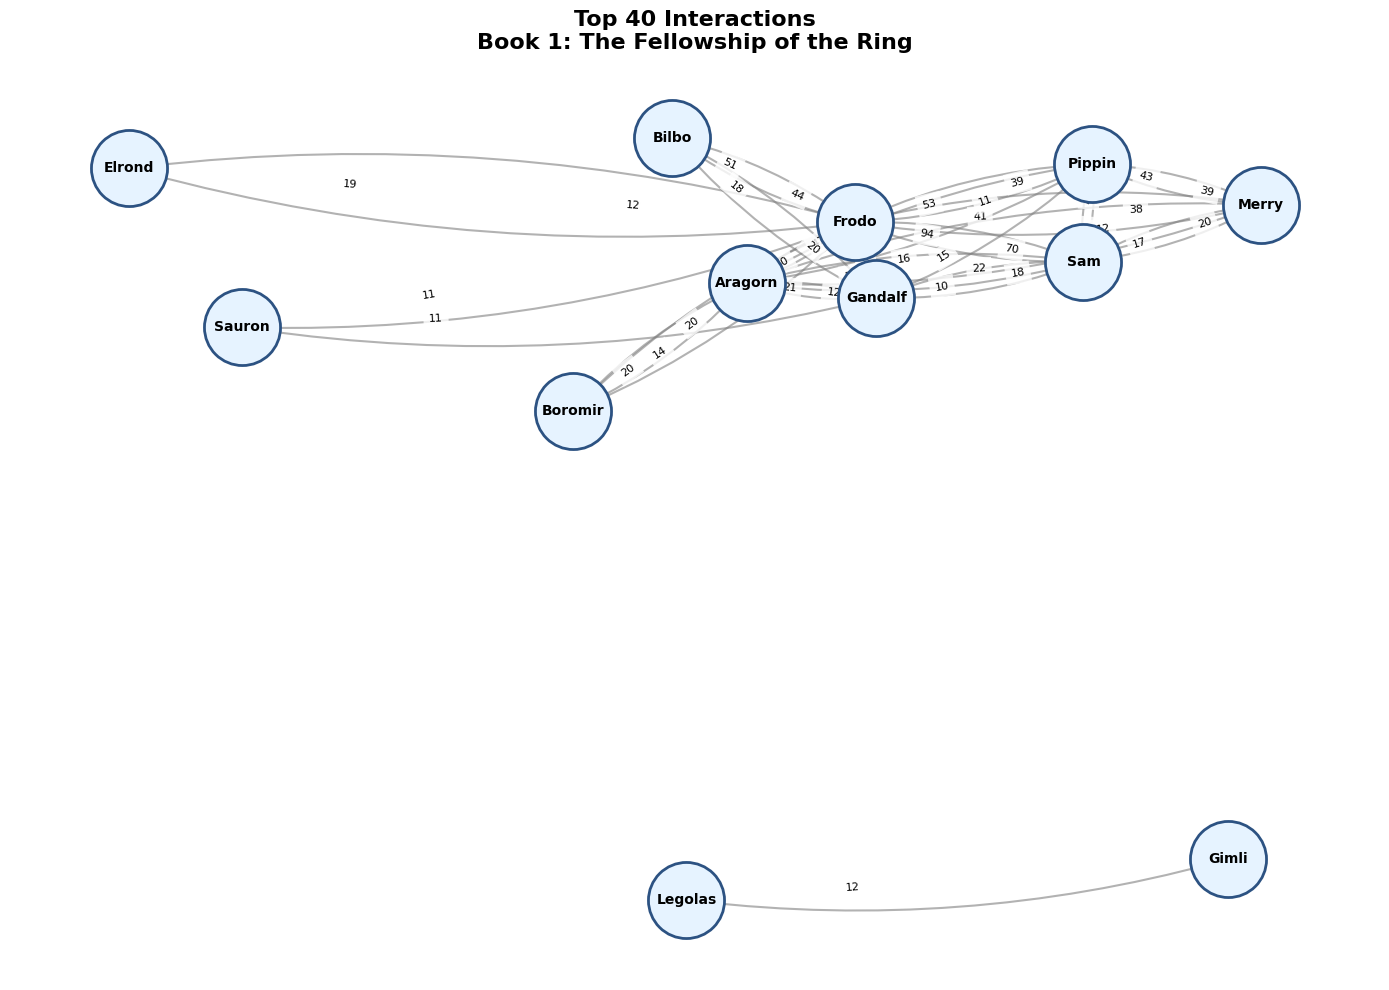

Generated graph for: Book 2: The Two Towers


Generated graph for: Book 3: The Return of the King


In [59]:
import matplotlib.pyplot as plt
import networkx as nx

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray'):
    """
    Generates a directed graph visualization for a given book's interaction data
    with customizable colors.
    """
    
    # 1. Setup the Graph
    G = nx.DiGraph()
    
    # 2. Filter Top Interactions
    # Sort by weight (count) and take the top N to avoid clutter
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes to the graph
    edge_labels = {}
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)
        edge_labels[(u, v)] = str(weight)

    # 3. Create the Plot
    plt.figure(figsize=(14, 10))
    
    # Layout: Spring layout often works best for social networks
    # k=1.5 increases the distance between nodes
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=3000,
        node_color=node_color,   # Customizable light color
        edgecolors=border_color, # Customizable dark border
        linewidths=2
    )
    
    # Draw Edges (Curved)
    # connectionstyle='arc3, rad=0.1' creates the curve so A->B and B->A don't overlap
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=20,
        edge_color=edge_color,   # Customizable edge color
        width=1.5,
        connectionstyle='arc3, rad=0.1',
        alpha=0.6
    )
    
    # Draw Labels (Character Names)
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Interaction Counts)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.3, # Offset slightly from center
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    plt.title(f"Top {top_n} Interactions\n{book_title}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    # 4. Save and Show
    # plt.savefig(filename, dpi=150, bbox_inches="tight") # Uncomment to save locally
    print(f"Generated graph for: {book_title}")
    plt.show()

# --- EXECUTE VISUALIZATION FOR ALL BOOKS ---
# Assumes 'edges_b1', 'edges_b2', and 'edges_b3' exist from the previous Analysis step.

print("Generating visualizations...")

# Book 1: Keep original blue scheme
plot_and_save_network(edges_b1, "Book 1: The Fellowship of the Ring", "network_book1.png", 
                      node_color='#e6f3ff', border_color='#2c5282', edge_color='gray')

# Book 2: Light red scheme
plot_and_save_network(edges_b2, "Book 2: The Two Towers", "network_book2.png",
                      node_color='#ffe6e6', border_color='#822c2c', edge_color='#d39797')

# Book 3: Light green scheme
plot_and_save_network(edges_b3, "Book 3: The Return of the King", "network_book3.png",
                      node_color='#e6ffe6', border_color='#2c822c', edge_color='#97d397')

Generating visualizations...
Generated graph for: Book 1: The Fellowship of the Ring


Generated graph for: Book 2: The Two Towers


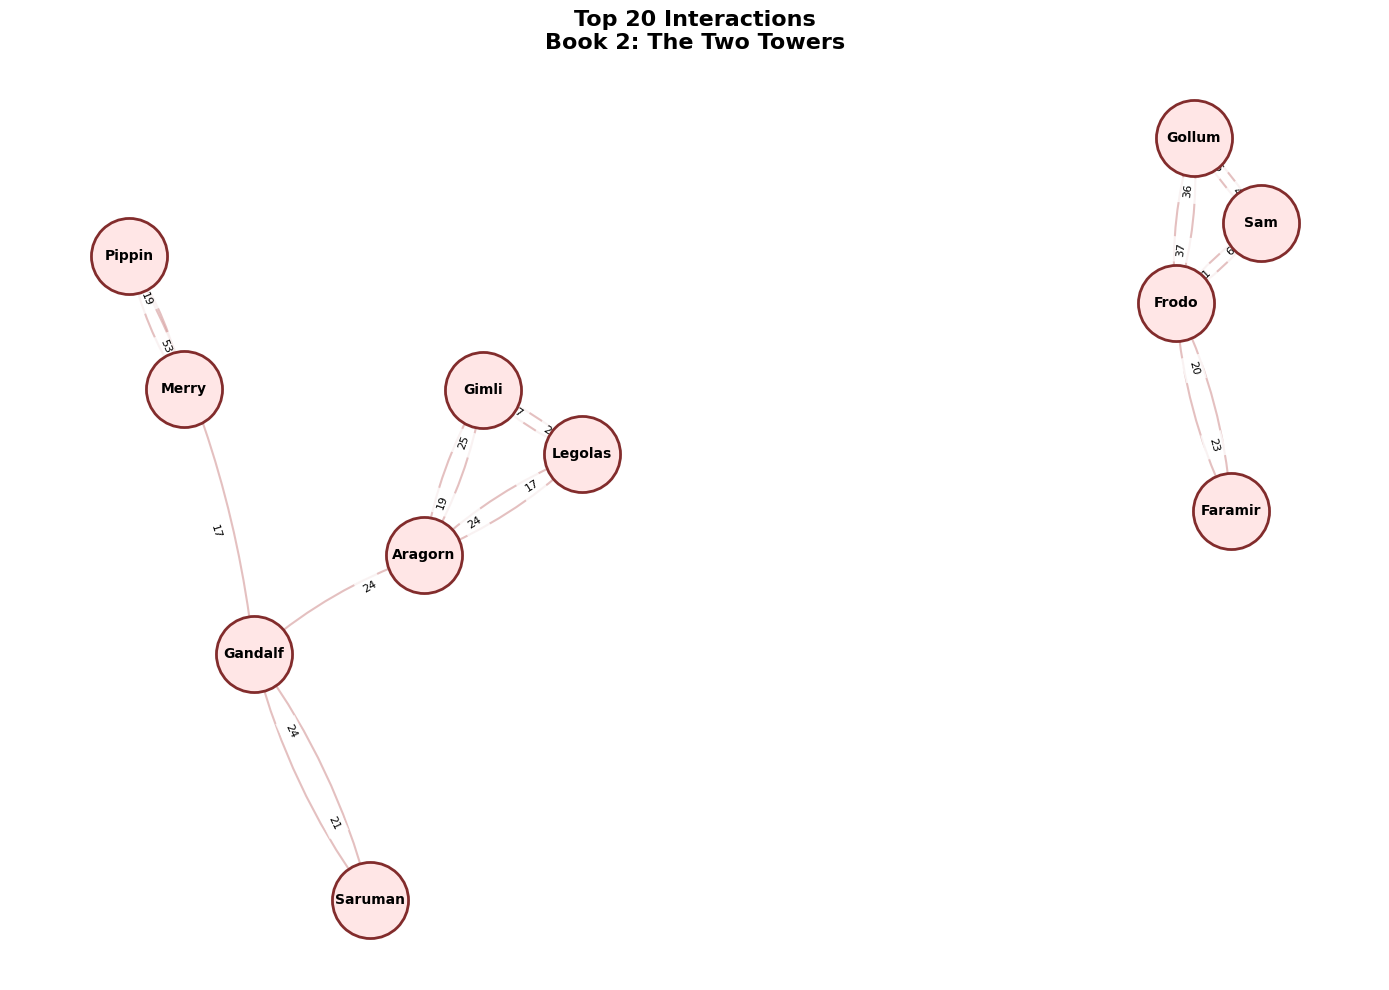

Generated graph for: Book 3: The Return of the King


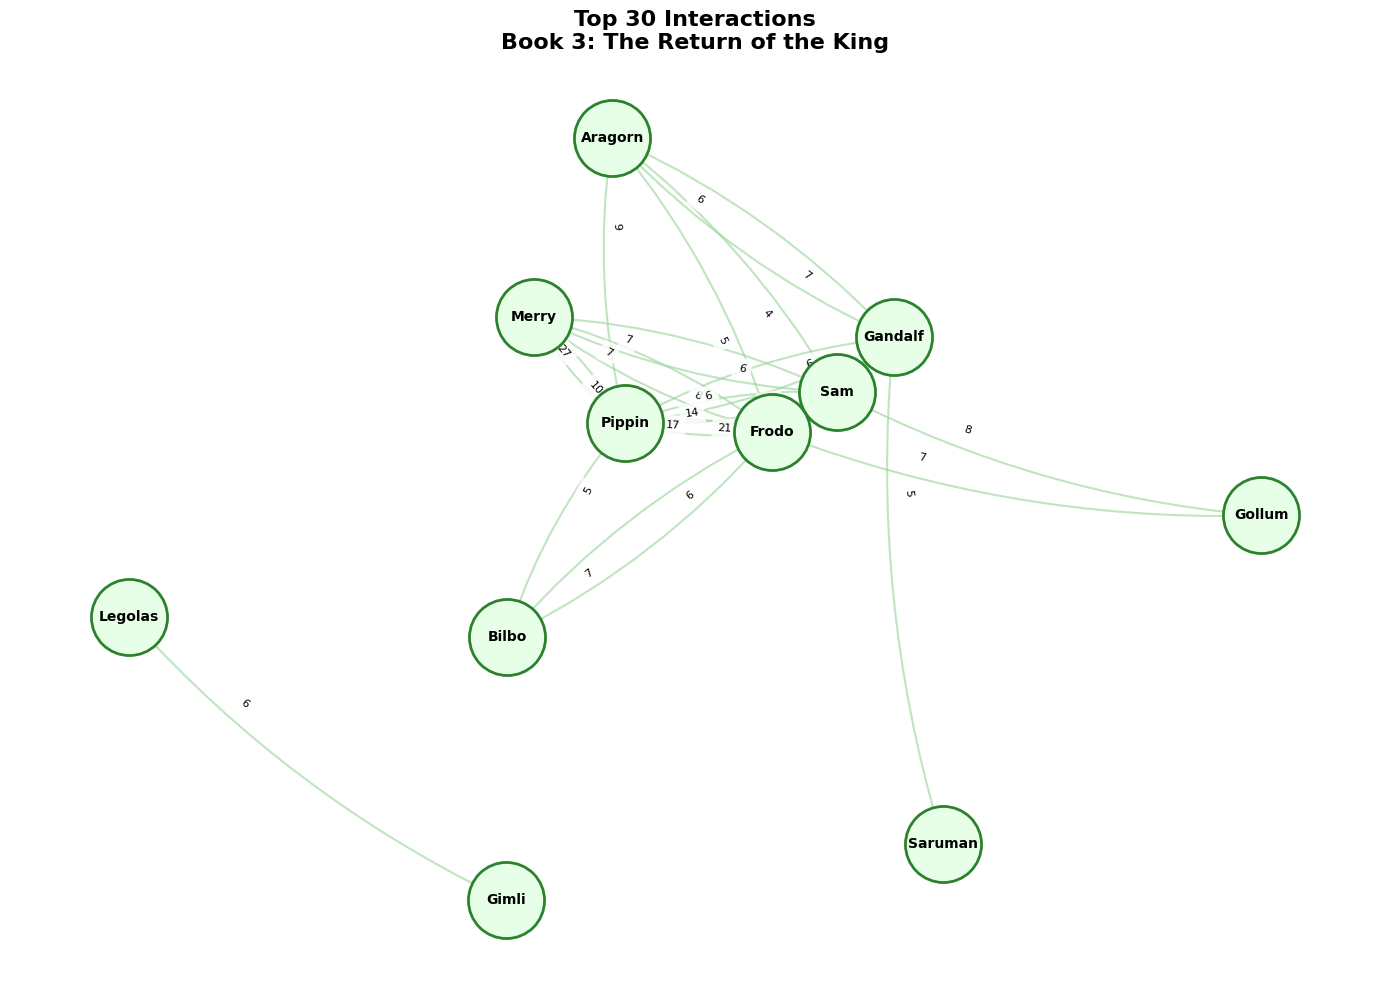

In [60]:
import matplotlib.pyplot as plt
import networkx as nx

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray'):
    """
    Generates a directed graph visualization for a given book's interaction data
    with customizable colors.
    """
    
    # 1. Setup the Graph
    G = nx.DiGraph()
    
    # 2. Filter Top Interactions
    # Sort by weight (count) and take the top N to avoid clutter
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes to the graph
    edge_labels = {}
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)
        edge_labels[(u, v)] = str(weight)

    # 3. Create the Plot
    plt.figure(figsize=(14, 10))
    
    # Layout: Spring layout often works best for social networks
    # k=1.5 increases the distance between nodes
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=3000,
        node_color=node_color,   # Customizable light color
        edgecolors=border_color, # Customizable dark border
        linewidths=2
    )
    
    # Draw Edges (Curved)
    # connectionstyle='arc3, rad=0.1' creates the curve so A->B and B->A don't overlap
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=20,
        edge_color=edge_color,   # Customizable edge color
        width=1.5,
        connectionstyle='arc3, rad=0.1',
        alpha=0.6
    )
    
    # Draw Labels (Character Names)
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Interaction Counts)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.3, # Offset slightly from center
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    plt.title(f"Top {top_n} Interactions\n{book_title}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    # 4. Save and Show
    # plt.savefig(filename, dpi=150, bbox_inches="tight") # Uncomment to save locally
    print(f"Generated graph for: {book_title}")
    plt.show()

# --- EXECUTE VISUALIZATION FOR ALL BOOKS ---
# Assumes 'edges_b1', 'edges_b2', and 'edges_b3' exist from the previous Analysis step.

print("Generating visualizations...")

# Book 1: Dense group (Fellowship), but window=15 limits noise. Top 25 is a sweet spot.
plot_and_save_network(edges_b1, "Book 1: The Fellowship of the Ring", "network_book1.png", 
                      top_n=25,
                      node_color='#e6f3ff', border_color='#2c5282', edge_color='gray')

# Book 2: Split storylines. Lower Top N (20) keeps the separate groups clear.
plot_and_save_network(edges_b2, "Book 2: The Two Towers", "network_book2.png",
                      top_n=20,
                      node_color='#ffe6e6', border_color='#822c2c', edge_color='#d39797')

# Book 3: Large convergence of characters. Top 30 captures the scale of the finale.
plot_and_save_network(edges_b3, "Book 3: The Return of the King", "network_book3.png",
                      top_n=30,
                      node_color='#e6ffe6', border_color='#2c822c', edge_color='#97d397')

Generating visualizations...
Generated graph for: Book 1: The Fellowship of the Ring


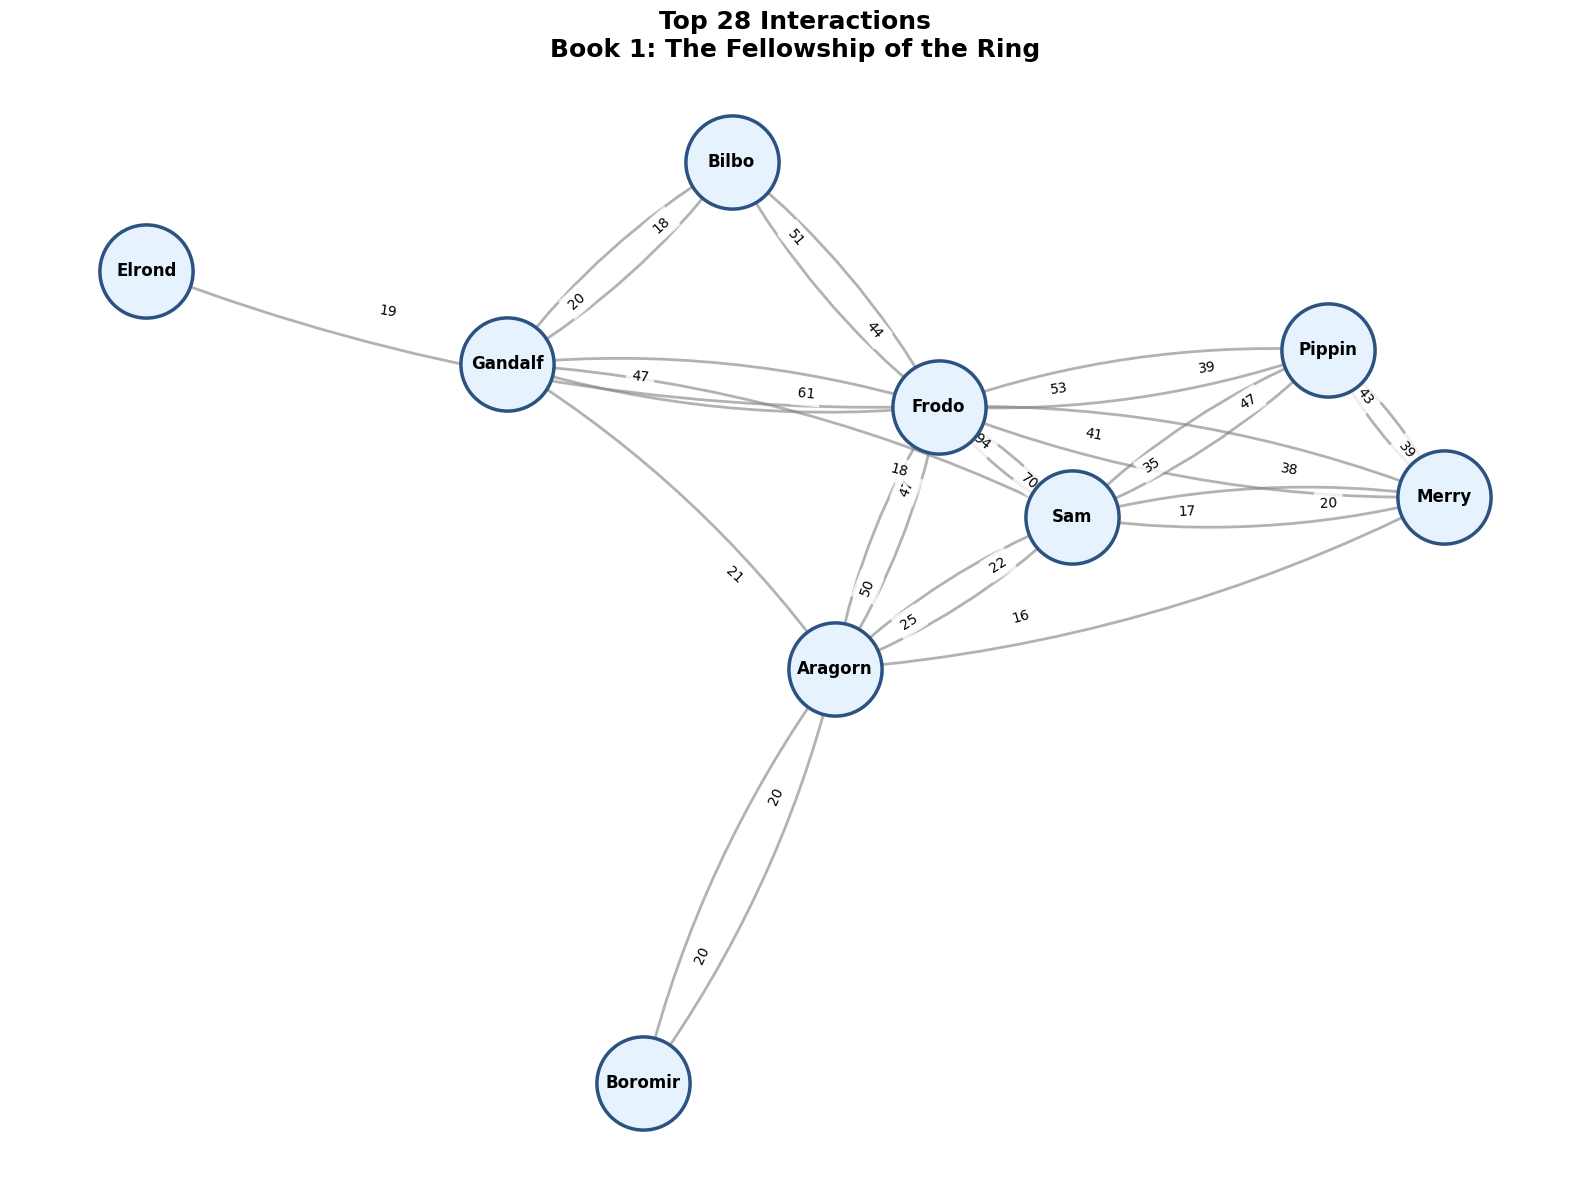

Generated graph for: Book 2: The Two Towers


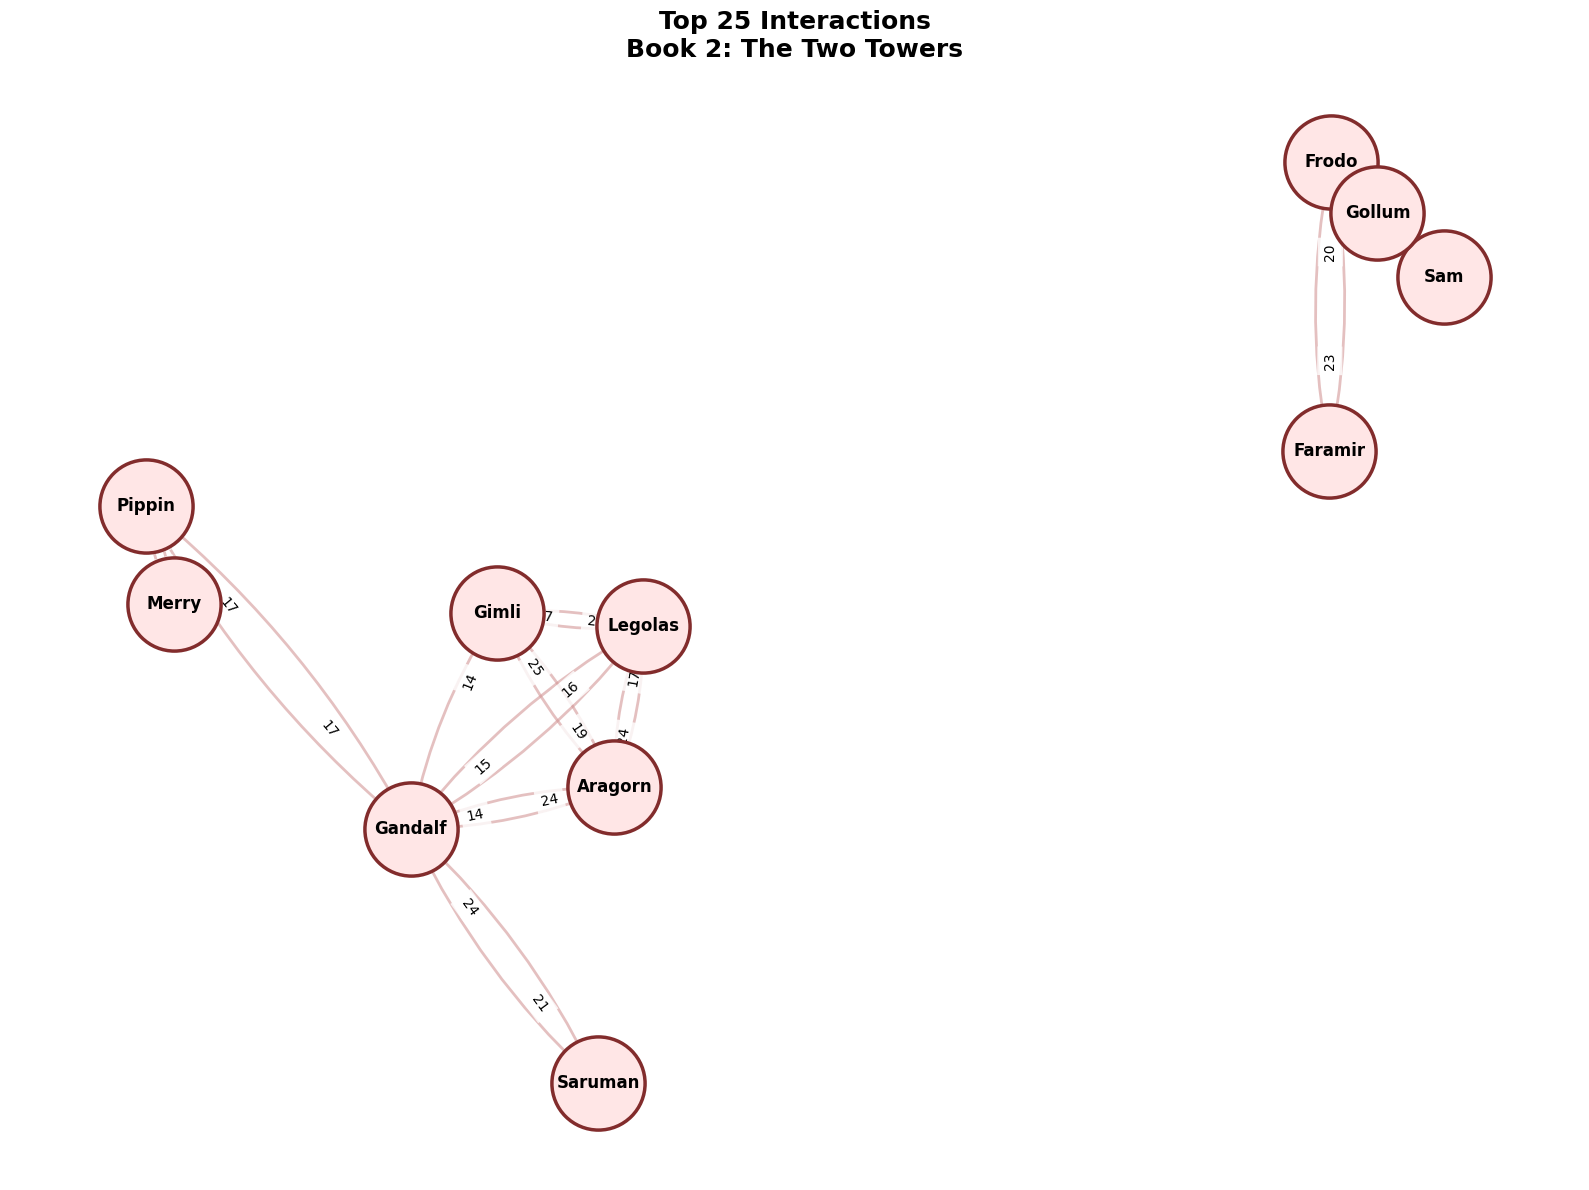

Generated graph for: Book 3: The Return of the King


In [61]:
import matplotlib.pyplot as plt
import networkx as nx

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray'):
    """
    Generates a directed graph visualization for a given book's interaction data
    with customizable colors.
    """
    
    # 1. Setup the Graph
    G = nx.DiGraph()
    
    # 2. Filter Top Interactions
    # Sort by weight (count) and take the top N to avoid clutter
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes to the graph
    edge_labels = {}
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)
        edge_labels[(u, v)] = str(weight)

    # 3. Create the Plot
    plt.figure(figsize=(16, 12))  # Increased figure size slightly for better readability
    
    # Layout: Spring layout often works best for social networks
    # k controls the distance between nodes. Increased to 2.0 to spread them out more.
    pos = nx.spring_layout(G, k=2.0, iterations=50, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=4500,          # Increased node size to fit larger text
        node_color=node_color,   # Customizable light color
        edgecolors=border_color, # Customizable dark border
        linewidths=2.5
    )
    
    # Draw Edges (Curved)
    # connectionstyle='arc3, rad=0.1' creates the curve so A->B and B->A don't overlap
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=25,            # Slightly larger arrows
        edge_color=edge_color,   # Customizable edge color
        width=2,                 # Slightly thicker lines
        connectionstyle='arc3, rad=0.1',
        alpha=0.6
    )
    
    # Draw Labels (Character Names)
    nx.draw_networkx_labels(
        G, pos,
        font_size=12,            # Larger font for names
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Interaction Counts)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=10,            # Larger font for the numbers
        label_pos=0.3, # Offset slightly from center
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    plt.title(f"Top {top_n} Interactions\n{book_title}", fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    # 4. Save and Show
    # plt.savefig(filename, dpi=150, bbox_inches="tight") # Uncomment to save locally
    print(f"Generated graph for: {book_title}")
    plt.show()

# --- EXECUTE VISUALIZATION FOR ALL BOOKS ---
# Assumes 'edges_b1', 'edges_b2', and 'edges_b3' exist from the previous Analysis step.

print("Generating visualizations...")

# Adjusted Top N numbers slightly up to balance "enough content" with the new cleaner window size.
# Book 1: The Fellowship forms. 28 captures the main group + key interactions (Gandalf/Bilbo etc).
plot_and_save_network(edges_b1, "Book 1: The Fellowship of the Ring", "network_book1.png", 
                      top_n=28,
                      node_color='#e6f3ff', border_color='#2c5282', edge_color='gray')

# Book 2: Split paths. 25 allows seeing the distinct groups (Frodo/Sam vs Aragorn/Gimli/Legolas) clearly.
plot_and_save_network(edges_b2, "Book 2: The Two Towers", "network_book2.png",
                      top_n=25,
                      node_color='#ffe6e6', border_color='#822c2c', edge_color='#d39797')

# Book 3: Massive convergence. 35 is needed to catch the secondary characters joining the fray.
plot_and_save_network(edges_b3, "Book 3: The Return of the King", "network_book3.png",
                      top_n=35,
                      node_color='#e6ffe6', border_color='#2c822c', edge_color='#97d397')

Generating visualizations...
Generated graph for: The Fellowship of the Ring


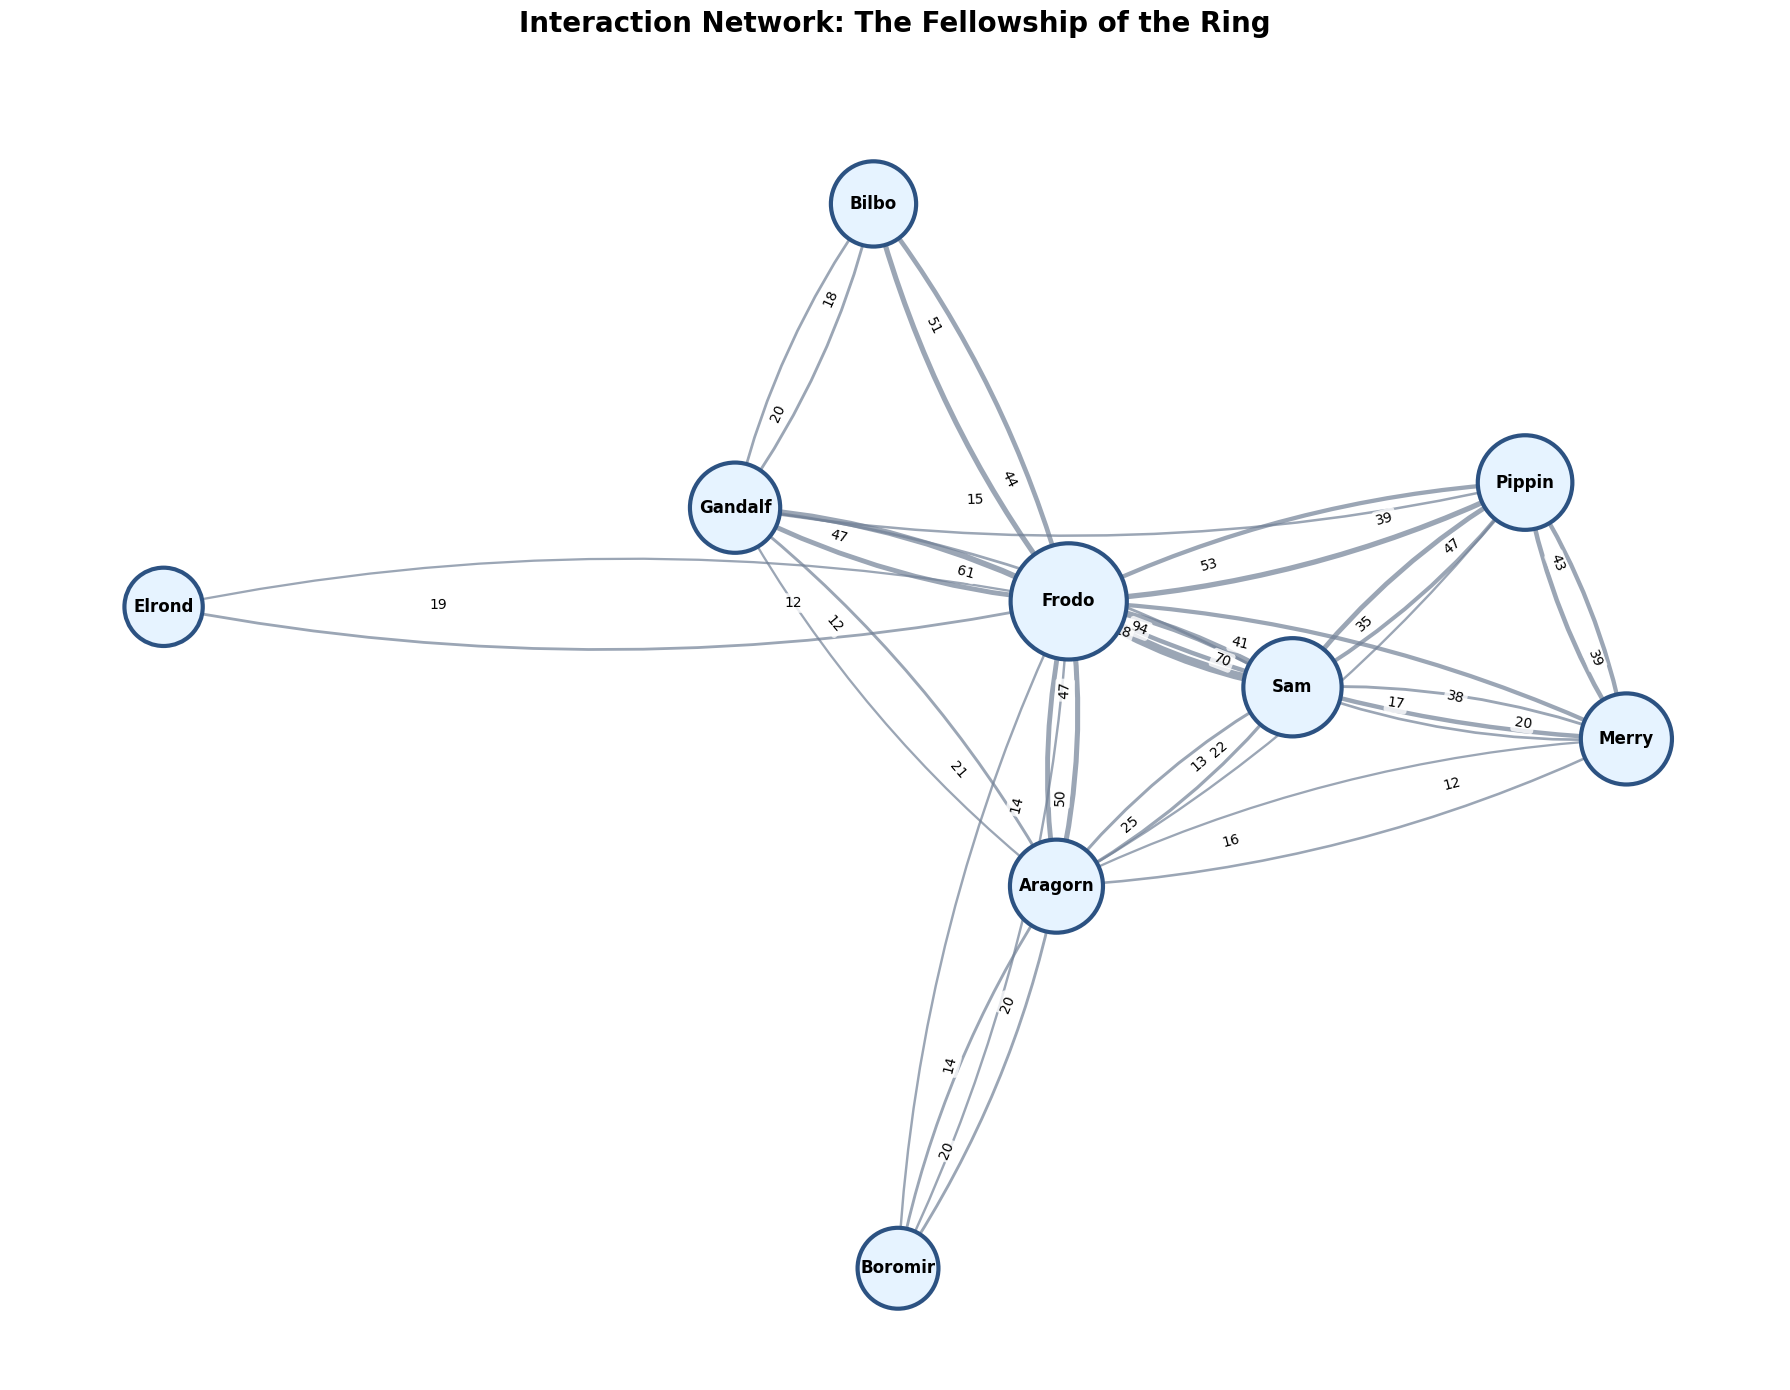

Generated graph for: The Two Towers


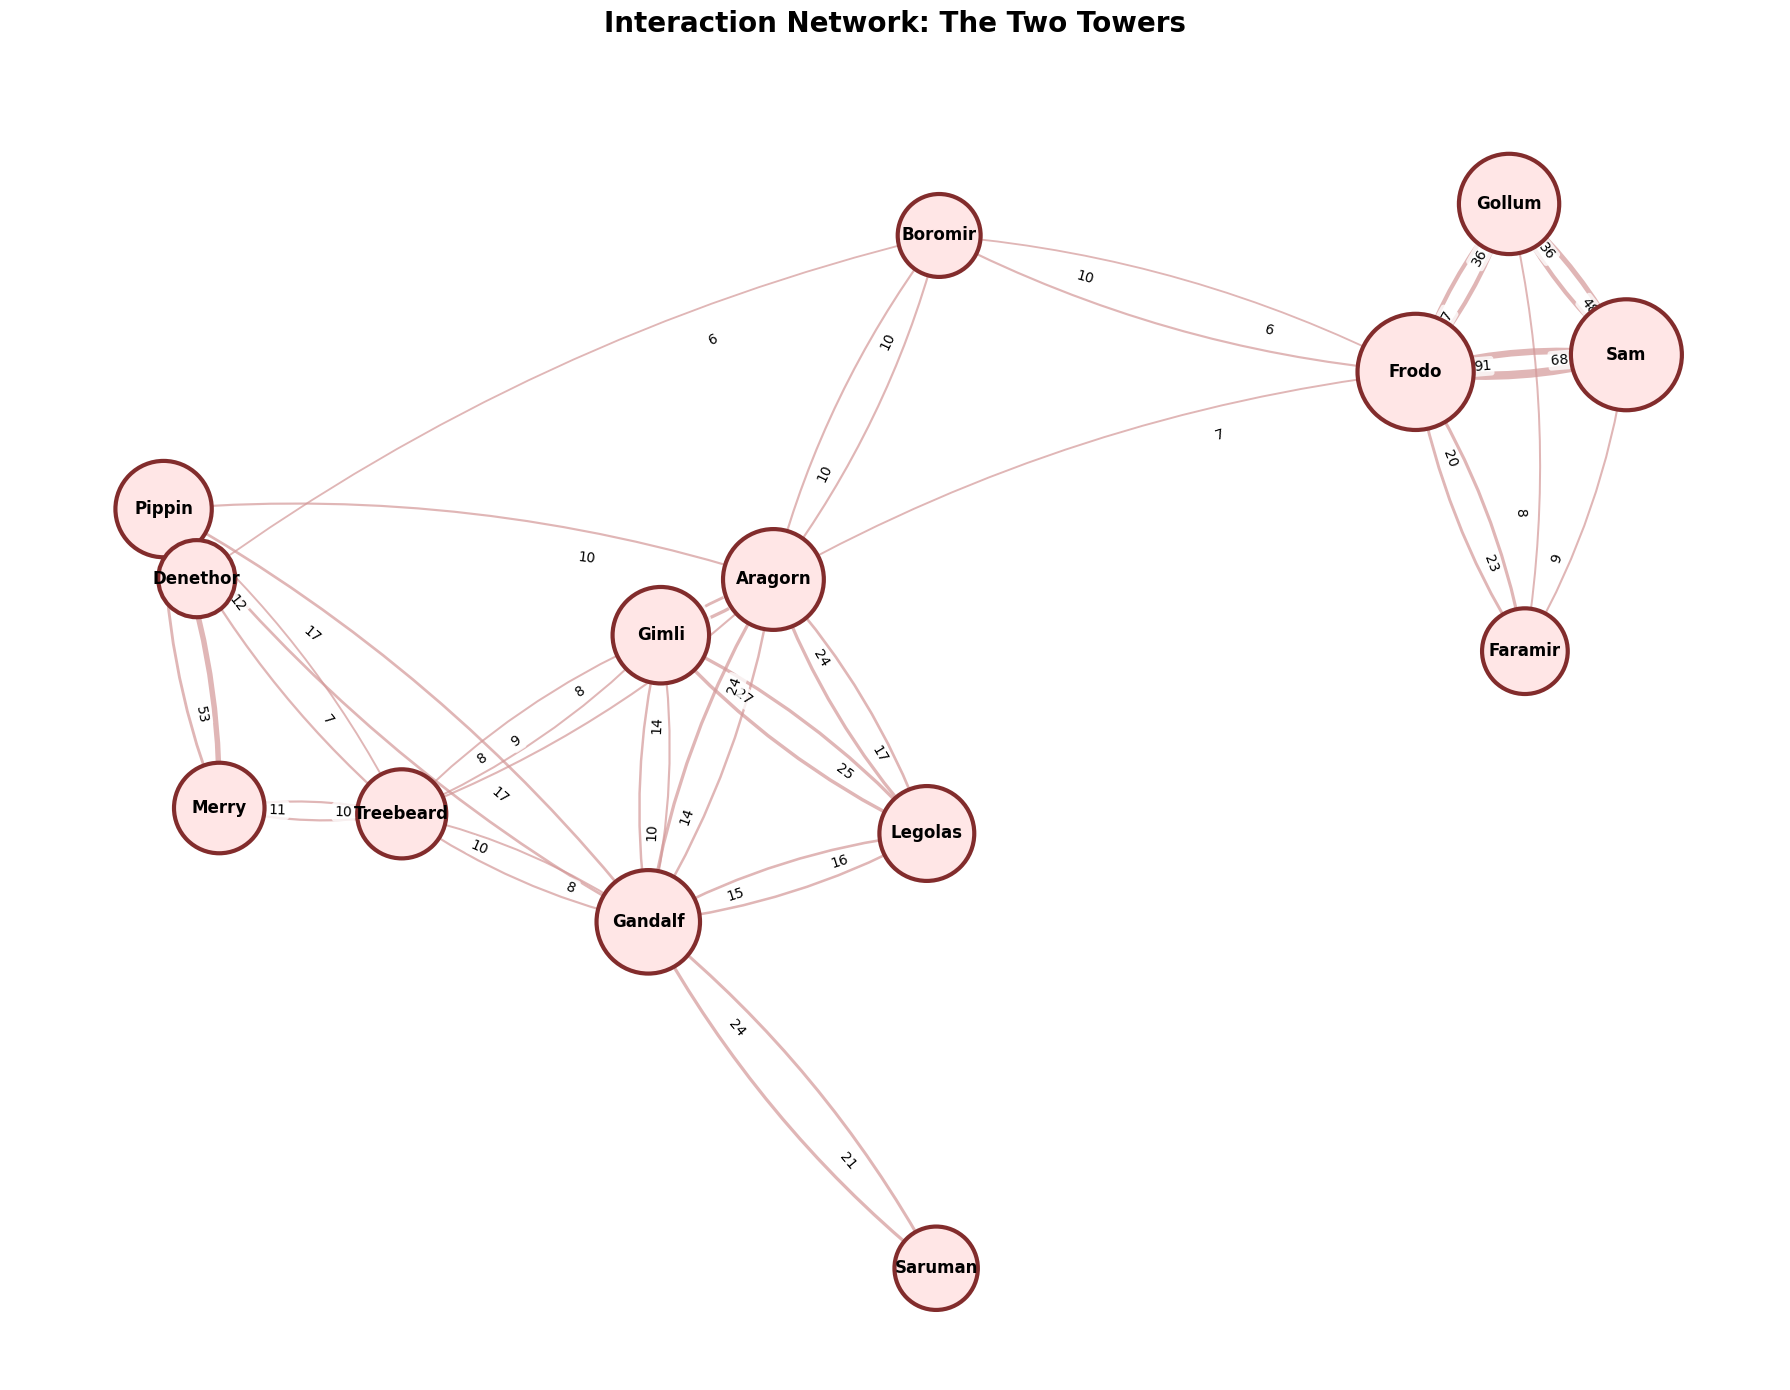

Generated graph for: The Return of the King


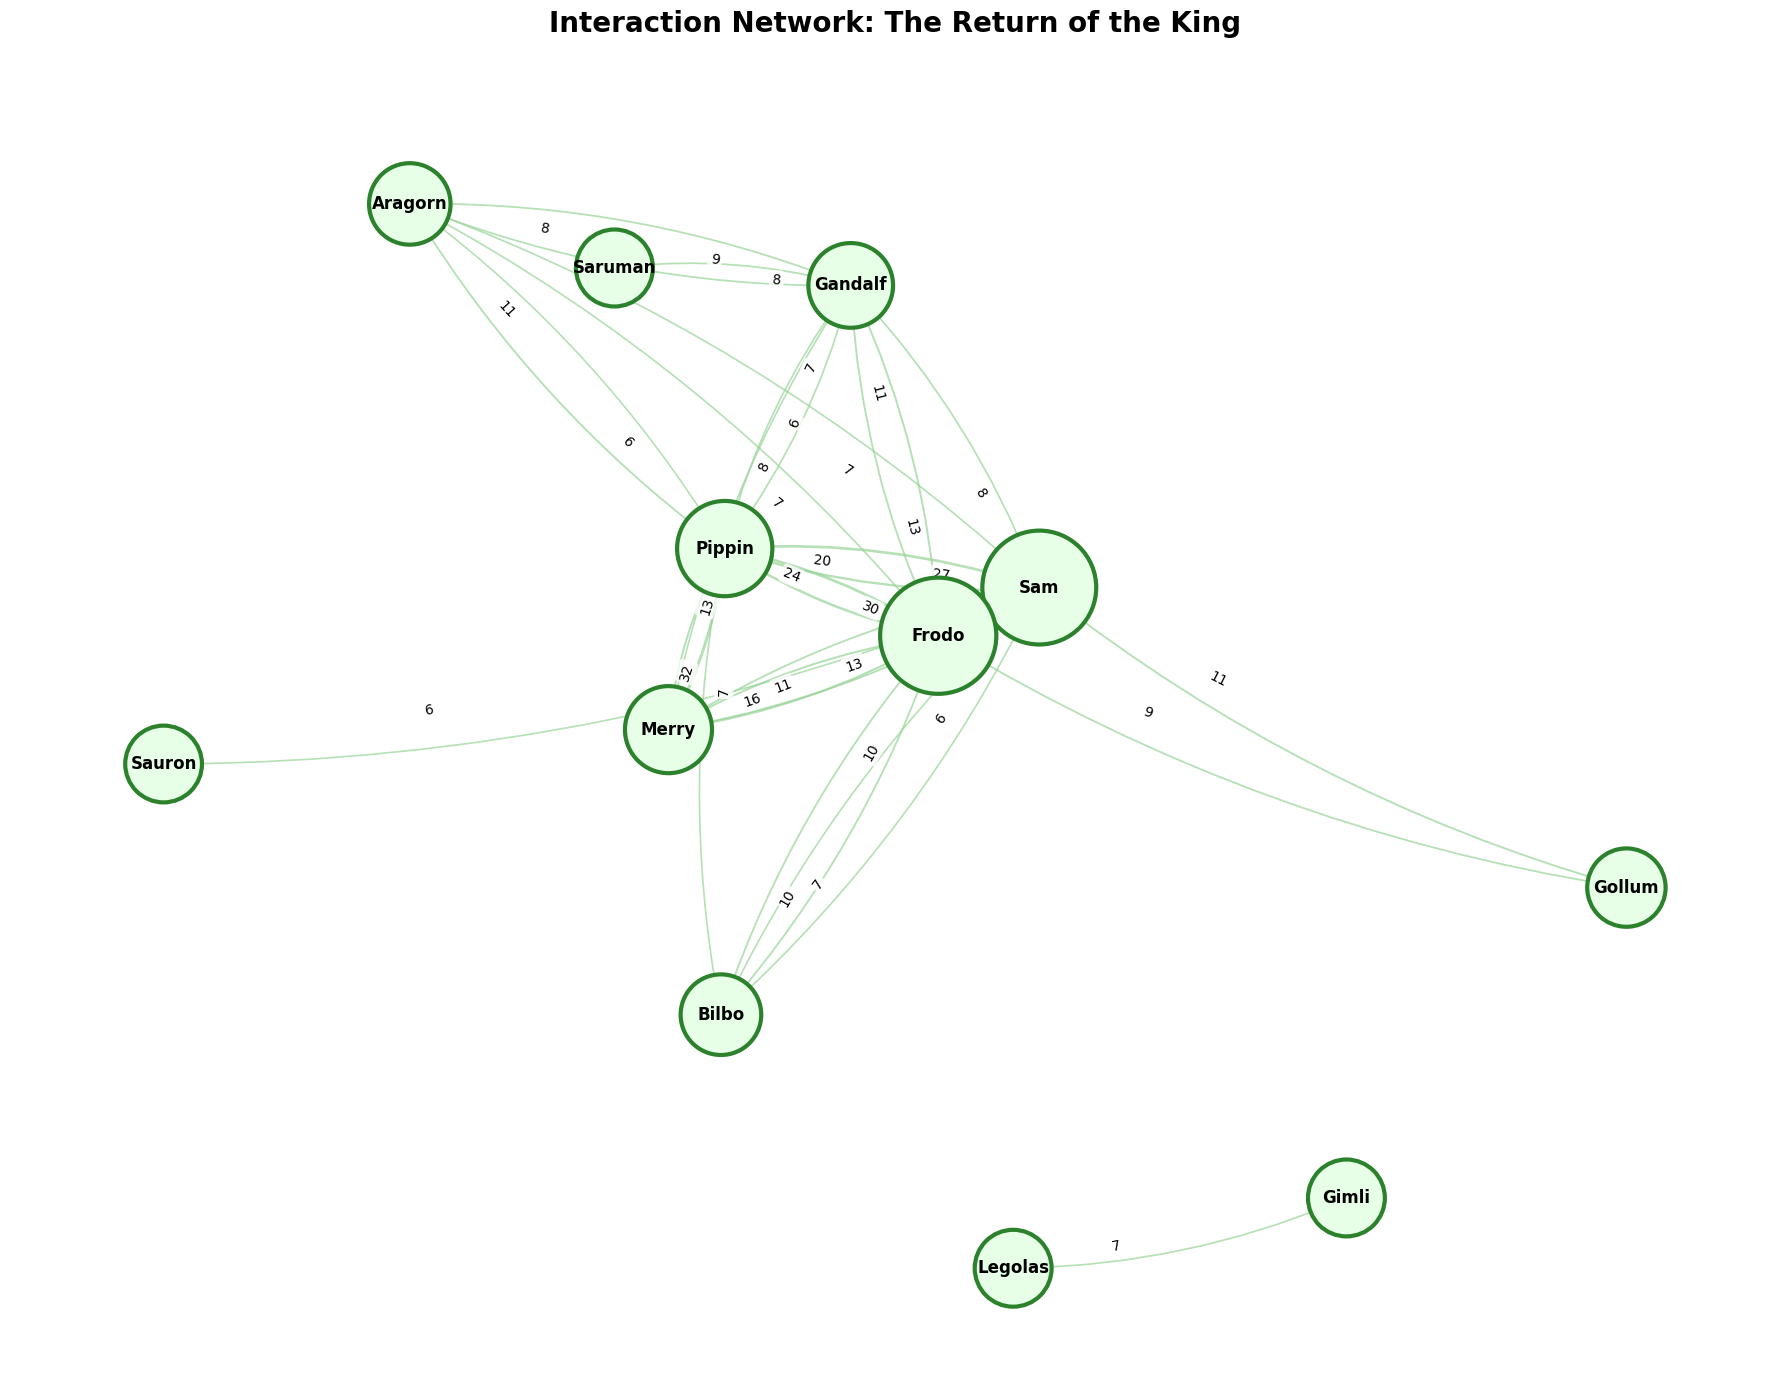

In [125]:
import matplotlib.pyplot as plt
import networkx as nx

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=50, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray'):
    """
    Generates a directed graph visualization for a given book's interaction data.
    Features:
    - Dynamic Node Size: Based on total interaction volume (Weighted Degree).
    - Dynamic Edge Width: Based on interaction frequency (Weight).
    - Curved Edges: To distinguish A->B from B->A.
    """
    
    # 1. Setup the Graph
    G = nx.DiGraph()
    
    # 2. Filter Top Interactions
    # Sort by weight (count) and take the top N to avoid clutter
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes to the graph
    edge_labels = {}
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)
        edge_labels[(u, v)] = str(weight)

    # 3. Calculate Dynamic Visual Properties
    
    # Node Size: Base size + Scaled by weighted degree (total interactions in/out)
    # This highlights the most active characters visually.
    d = dict(G.degree(weight='weight'))
    max_degree = max(d.values()) if d else 1
    # Minimum size 3000, max additional 3000 based on relative activity
    node_sizes = [3000 + (d[n] / max_degree * 4000) for n in G.nodes()]

    # Edge Width: Base width + Scaled by weight
    # This highlights the strongest relationships.
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    # Width ranges from 1.0 to 6.0
    widths = [1.0 + (w / max_weight * 5.0) for w in weights]

    # 4. Create the Plot
    plt.figure(figsize=(18, 14))  # Large canvas for high detail
    
    # Layout: Spring layout with high 'k' to separate clusters
    pos = nx.spring_layout(G, k=2.5, iterations=50, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,    # Dynamic sizes
        node_color=node_color,   # Customizable light color
        edgecolors=border_color, # Customizable dark border
        linewidths=3
    )
    
    # Draw Edges (Curved)
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=25,
        edge_color=edge_color,
        width=widths,            # Dynamic widths
        connectionstyle='arc3, rad=0.1',
        alpha=0.7
    )
    
    # Draw Labels (Character Names)
    # We offset labels slightly to ensure they are centered in the potentially large nodes
    nx.draw_networkx_labels(
        G, pos,
        font_size=12,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Interaction Counts)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=10,
        label_pos=0.3, 
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2')
    )

    plt.title(f"Interaction Network: {book_title}\n", 
              fontsize=20, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    # 5. Save and Show
    # plt.savefig(filename, dpi=300, bbox_inches="tight") # High DPI for best quality
    print(f"Generated graph for: {book_title}")
    plt.show()

# --- EXECUTE VISUALIZATION FOR ALL BOOKS ---
# Assumes 'edges_b1', 'edges_b2', and 'edges_b3' exist from the previous Analysis step.

print("Generating visualizations...")

# Book 1: Blue Theme
# Top 28 captures the Fellowship + Bilbo/Elrond context
plot_and_save_network(edges_b1, "The Fellowship of the Ring", "network_book1.png", 
                      top_n=35,
                      node_color='#e6f3ff', border_color='#2c5282', edge_color='#718096')

# Book 2: Red Theme
# Top 25 cleanly separates the Three Hunters, Frodo/Sam, and Merry/Pippin groups
plot_and_save_network(edges_b2, "The Two Towers", "network_book2.png",
                      top_n=44,
                      node_color='#ffe6e6', border_color='#822c2c', edge_color='#d39797')

# Book 3: Green Theme
# Top 35 is necessary to show the massive convergence of all plotlines
plot_and_save_network(edges_b3, "The Return of the King", "network_book3.png",
                      top_n=34,
                      node_color='#e6ffe6', border_color='#2c822c', edge_color='#97d397')

Generating visualizations...
Generated graph for: The Fellowship of the Ring


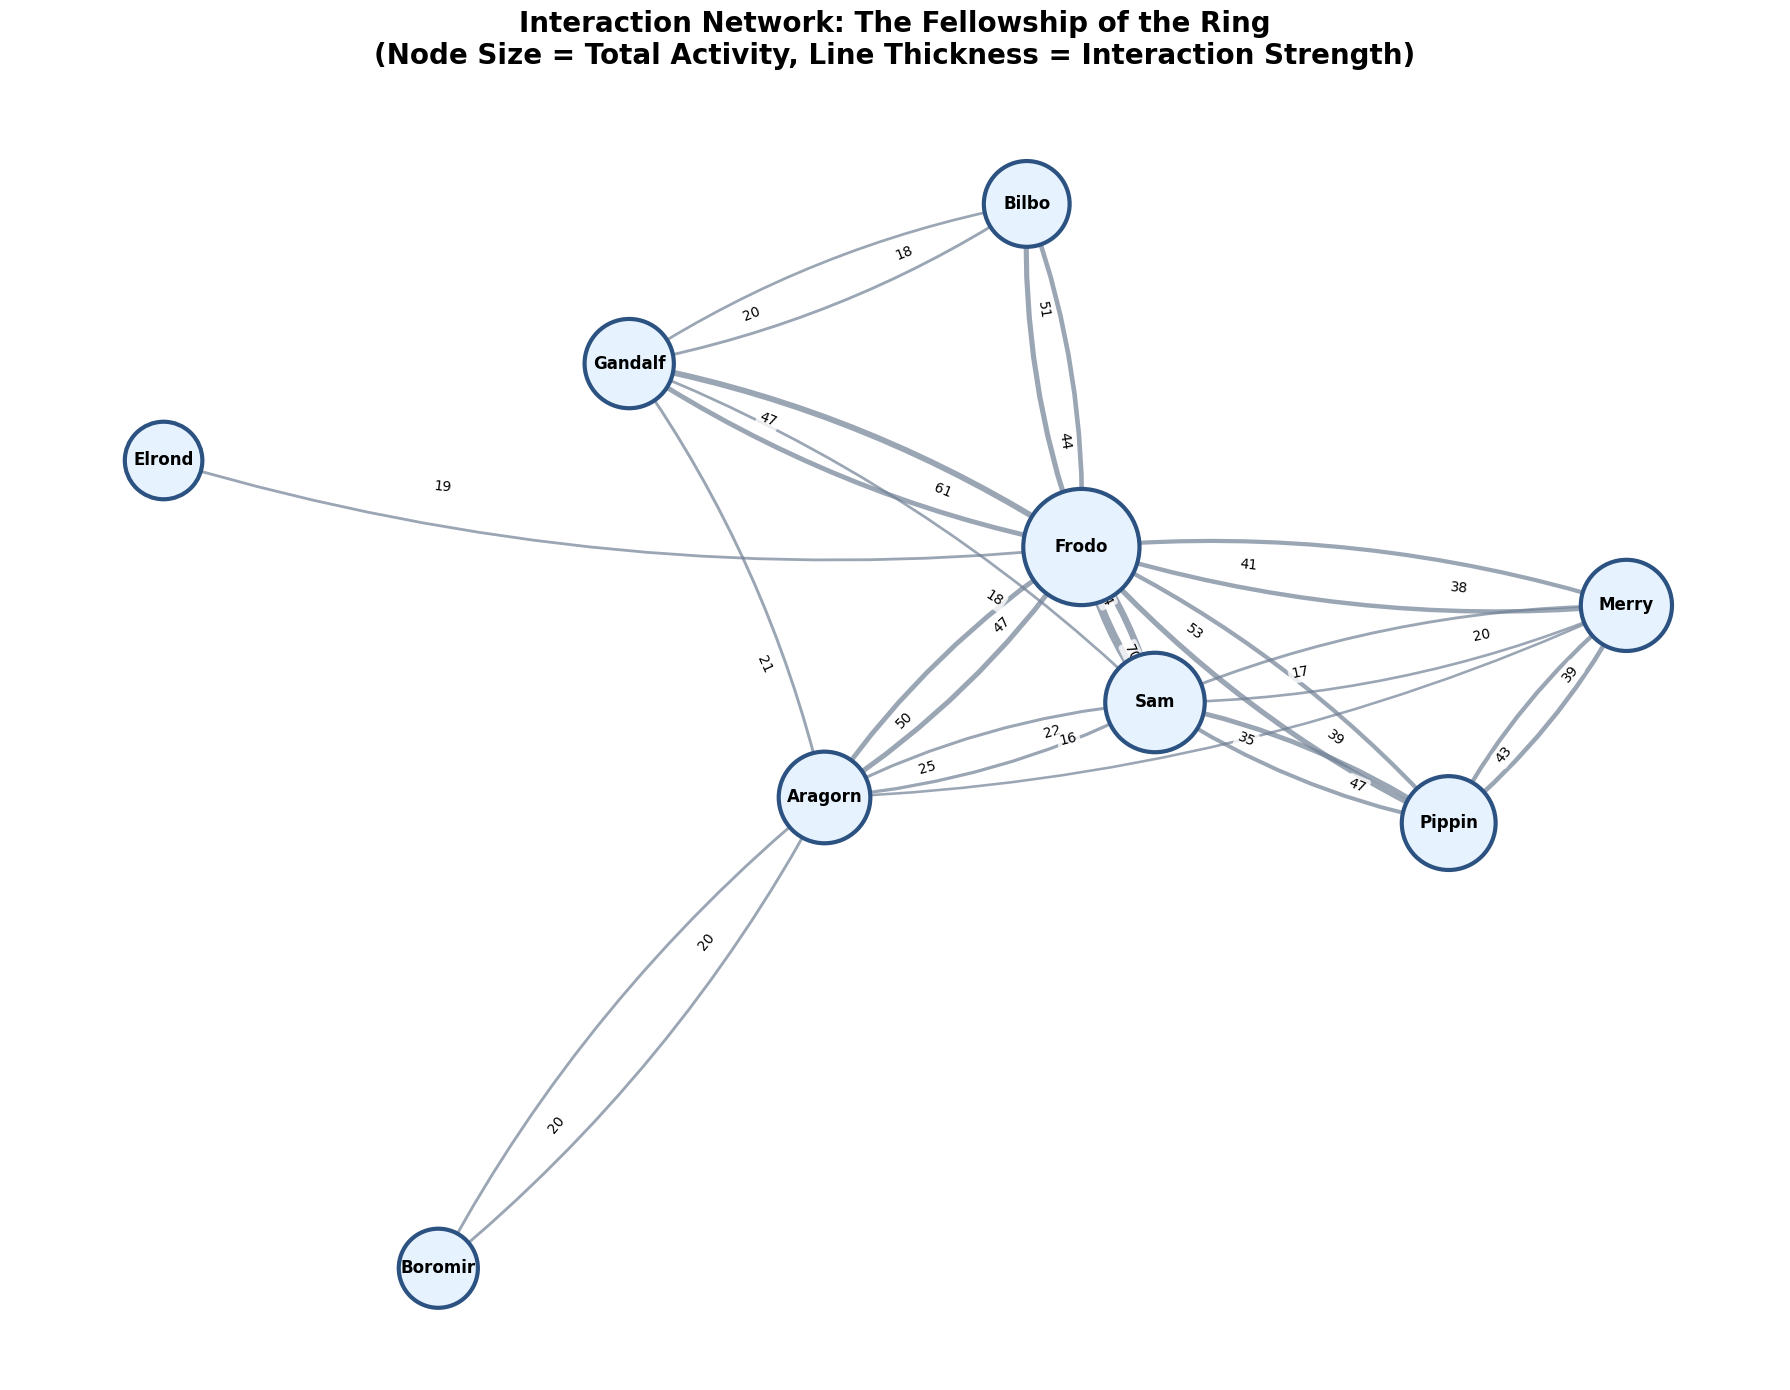

Generated graph for: The Two Towers


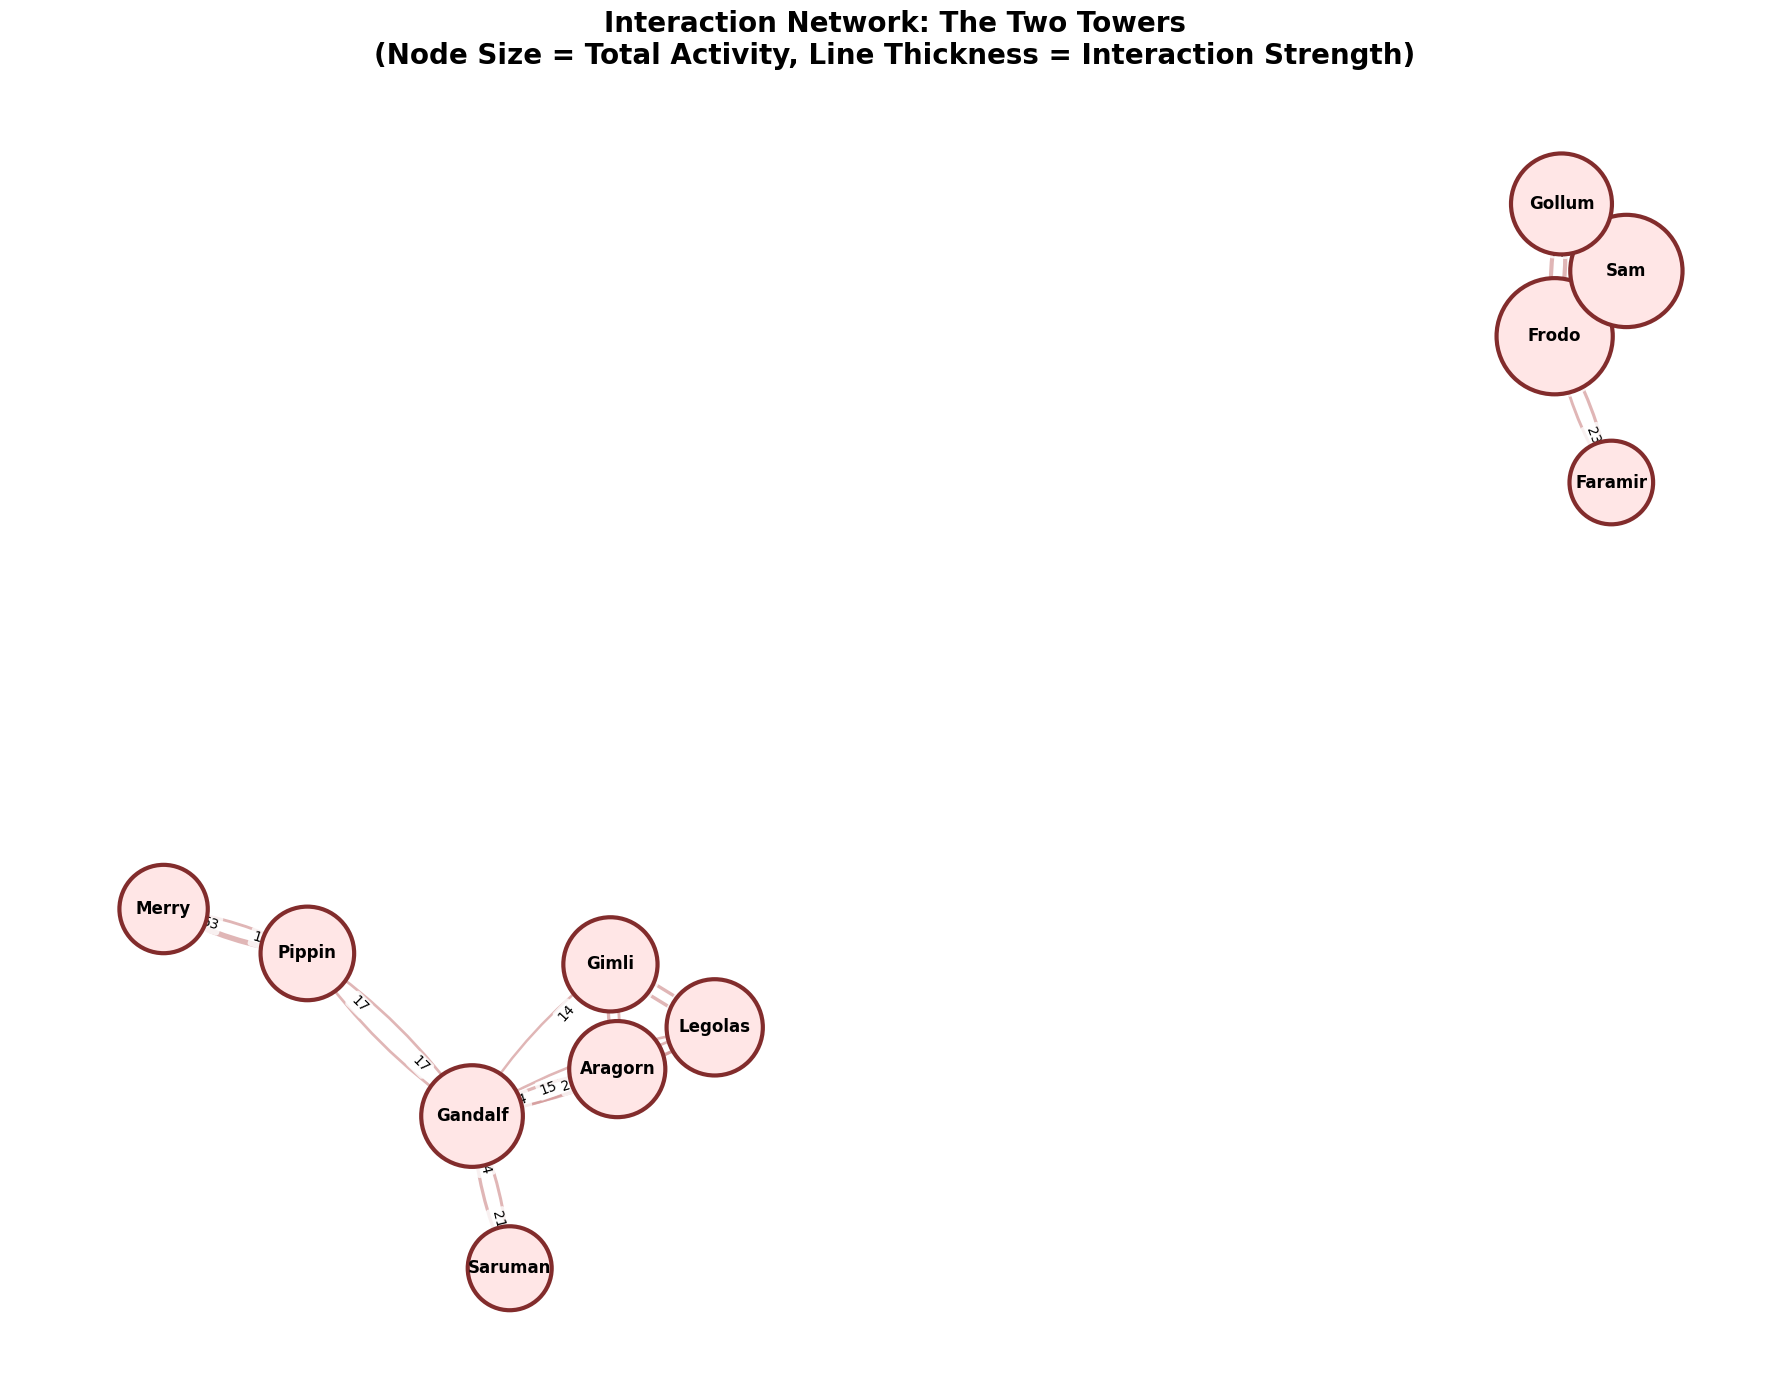

Generated graph for: The Return of the King


In [128]:
import matplotlib.pyplot as plt
import networkx as nx

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray'):
    """
    Generates a directed graph visualization for a given book's interaction data.
    Features:
    - Dynamic Node Size: Based on total interaction volume (Weighted Degree).
    - Dynamic Edge Width: Based on interaction frequency (Weight).
    - Curved Edges: To distinguish A->B from B->A.
    """
    
    # 1. Setup the Graph
    G = nx.DiGraph()
    
    # 2. Filter Top Interactions
    # Sort by weight (count) and take the top N to avoid clutter
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes to the graph
    edge_labels = {}
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)
        edge_labels[(u, v)] = str(weight)

    # 3. Calculate Dynamic Visual Properties
    
    # Node Size: Base size + Scaled by weighted degree (total interactions in/out)
    # This highlights the most active characters visually.
    d = dict(G.degree(weight='weight'))
    max_degree = max(d.values()) if d else 1
    # Minimum size 3000, max additional 3000 based on relative activity
    node_sizes = [3000 + (d[n] / max_degree * 4000) for n in G.nodes()]

    # Edge Width: Base width + Scaled by weight
    # This highlights the strongest relationships.
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    # Width ranges from 1.0 to 6.0
    widths = [1.0 + (w / max_weight * 5.0) for w in weights]

    # 4. Create the Plot
    plt.figure(figsize=(18, 14))  # Large canvas for high detail
    
    # Layout: Spring layout with increased spacing and iterations to prevent overlap
    # - k=4.0: Increases the repulsive force between nodes (was 2.5)
    # - iterations=200: Gives the algorithm more time to find a good layout (was 50)
    pos = nx.spring_layout(G, k=4.0, iterations=200, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,    # Dynamic sizes
        node_color=node_color,   # Customizable light color
        edgecolors=border_color, # Customizable dark border
        linewidths=3
    )
    
    # Draw Edges (Curved)
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=25,
        edge_color=edge_color,
        width=widths,            # Dynamic widths
        connectionstyle='arc3, rad=0.1',
        alpha=0.7
    )
    
    # Draw Labels (Character Names)
    # We offset labels slightly to ensure they are centered in the potentially large nodes
    nx.draw_networkx_labels(
        G, pos,
        font_size=12,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Interaction Counts)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=10,
        label_pos=0.3, 
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2')
    )

    plt.title(f"Interaction Network: {book_title}\n(Node Size = Total Activity, Line Thickness = Interaction Strength)", 
              fontsize=20, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    # 5. Save and Show
    # plt.savefig(filename, dpi=300, bbox_inches="tight") # High DPI for best quality
    print(f"Generated graph for: {book_title}")
    plt.show()

# --- EXECUTE VISUALIZATION FOR ALL BOOKS ---
# Assumes 'edges_b1', 'edges_b2', and 'edges_b3' exist from the previous Analysis step.

print("Generating visualizations...")

# Book 1: Blue Theme
# Top 28 captures the Fellowship + Bilbo/Elrond context
plot_and_save_network(edges_b1, "The Fellowship of the Ring", "network_book1.png", 
                      top_n=28,
                      node_color='#e6f3ff', border_color='#2c5282', edge_color='#718096')

# Book 2: Red Theme
# Top 25 cleanly separates the Three Hunters, Frodo/Sam, and Merry/Pippin groups
plot_and_save_network(edges_b2, "The Two Towers", "network_book2.png",
                      top_n=25,
                      node_color='#ffe6e6', border_color='#822c2c', edge_color='#d39797')

# Book 3: Green Theme
# Top 35 is necessary to show the massive convergence of all plotlines
plot_and_save_network(edges_b3, "The Return of the King", "network_book3.png",
                      top_n=50,
                      node_color='#e6ffe6', border_color='#2c822c', edge_color='#97d397')

Generating network graphs...
Processing The Fellowship of the Ring...


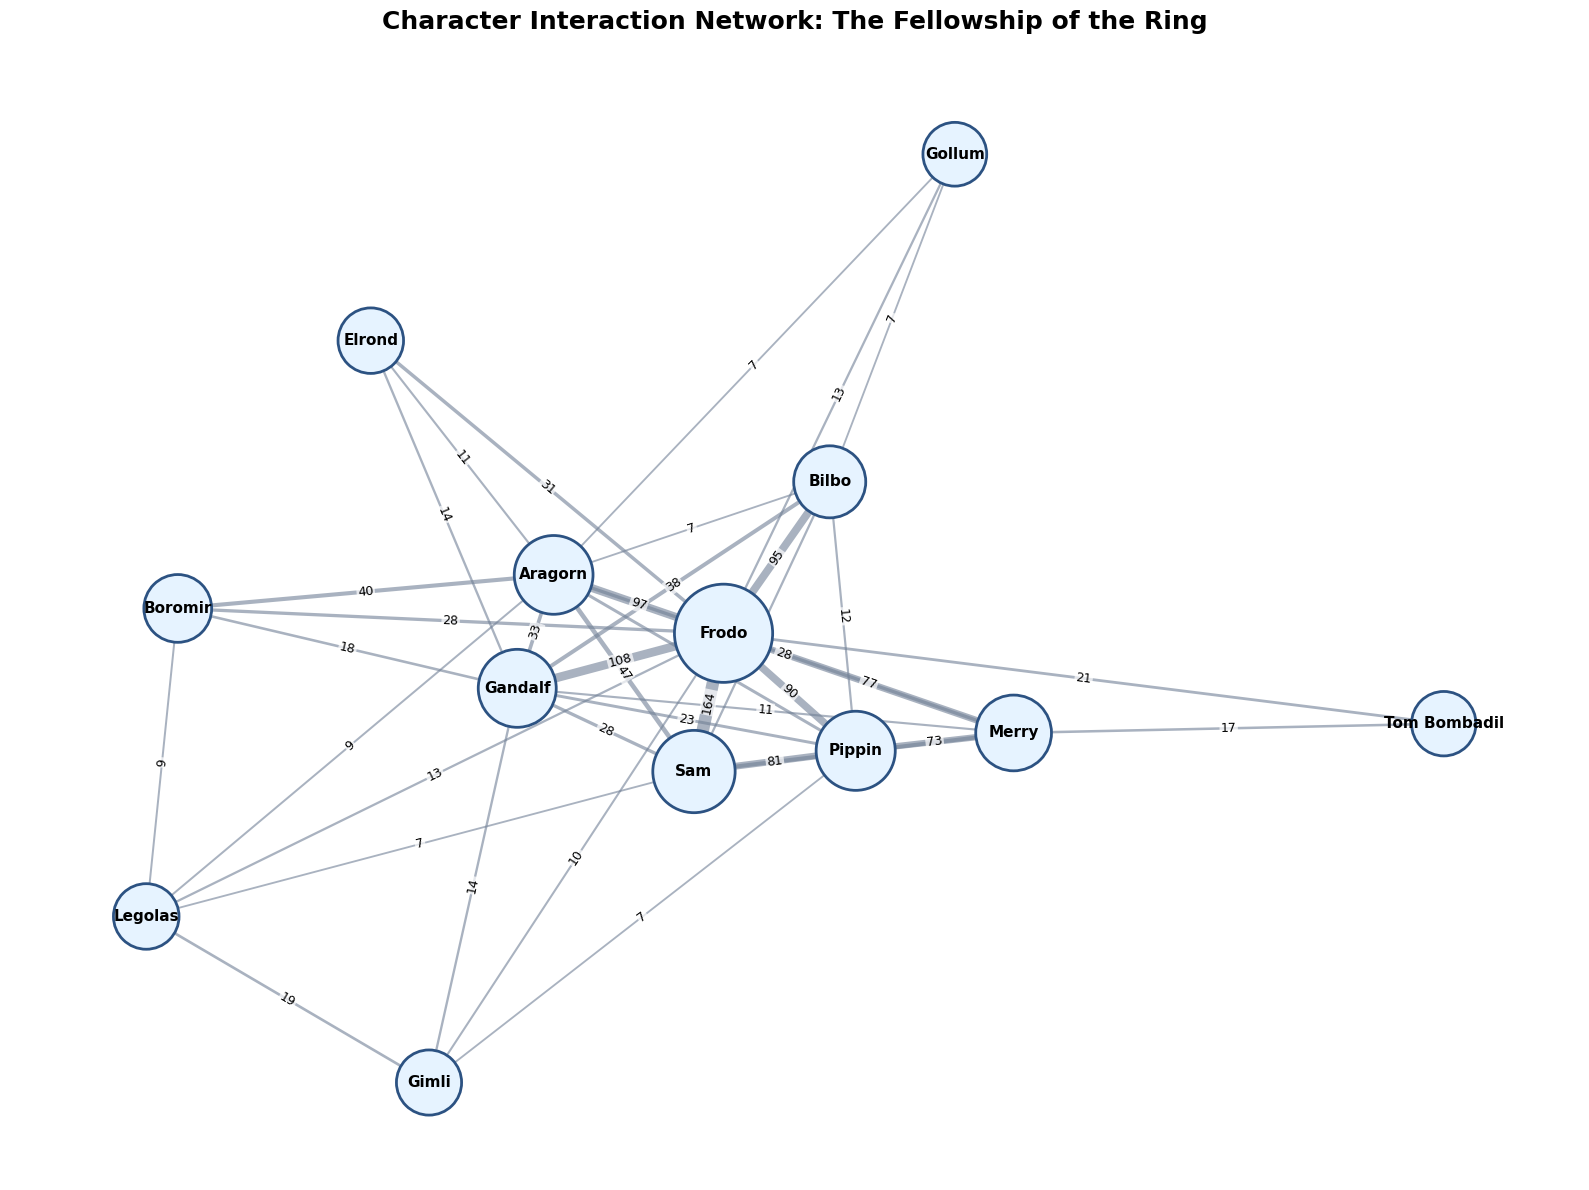

Processing The Two Towers...


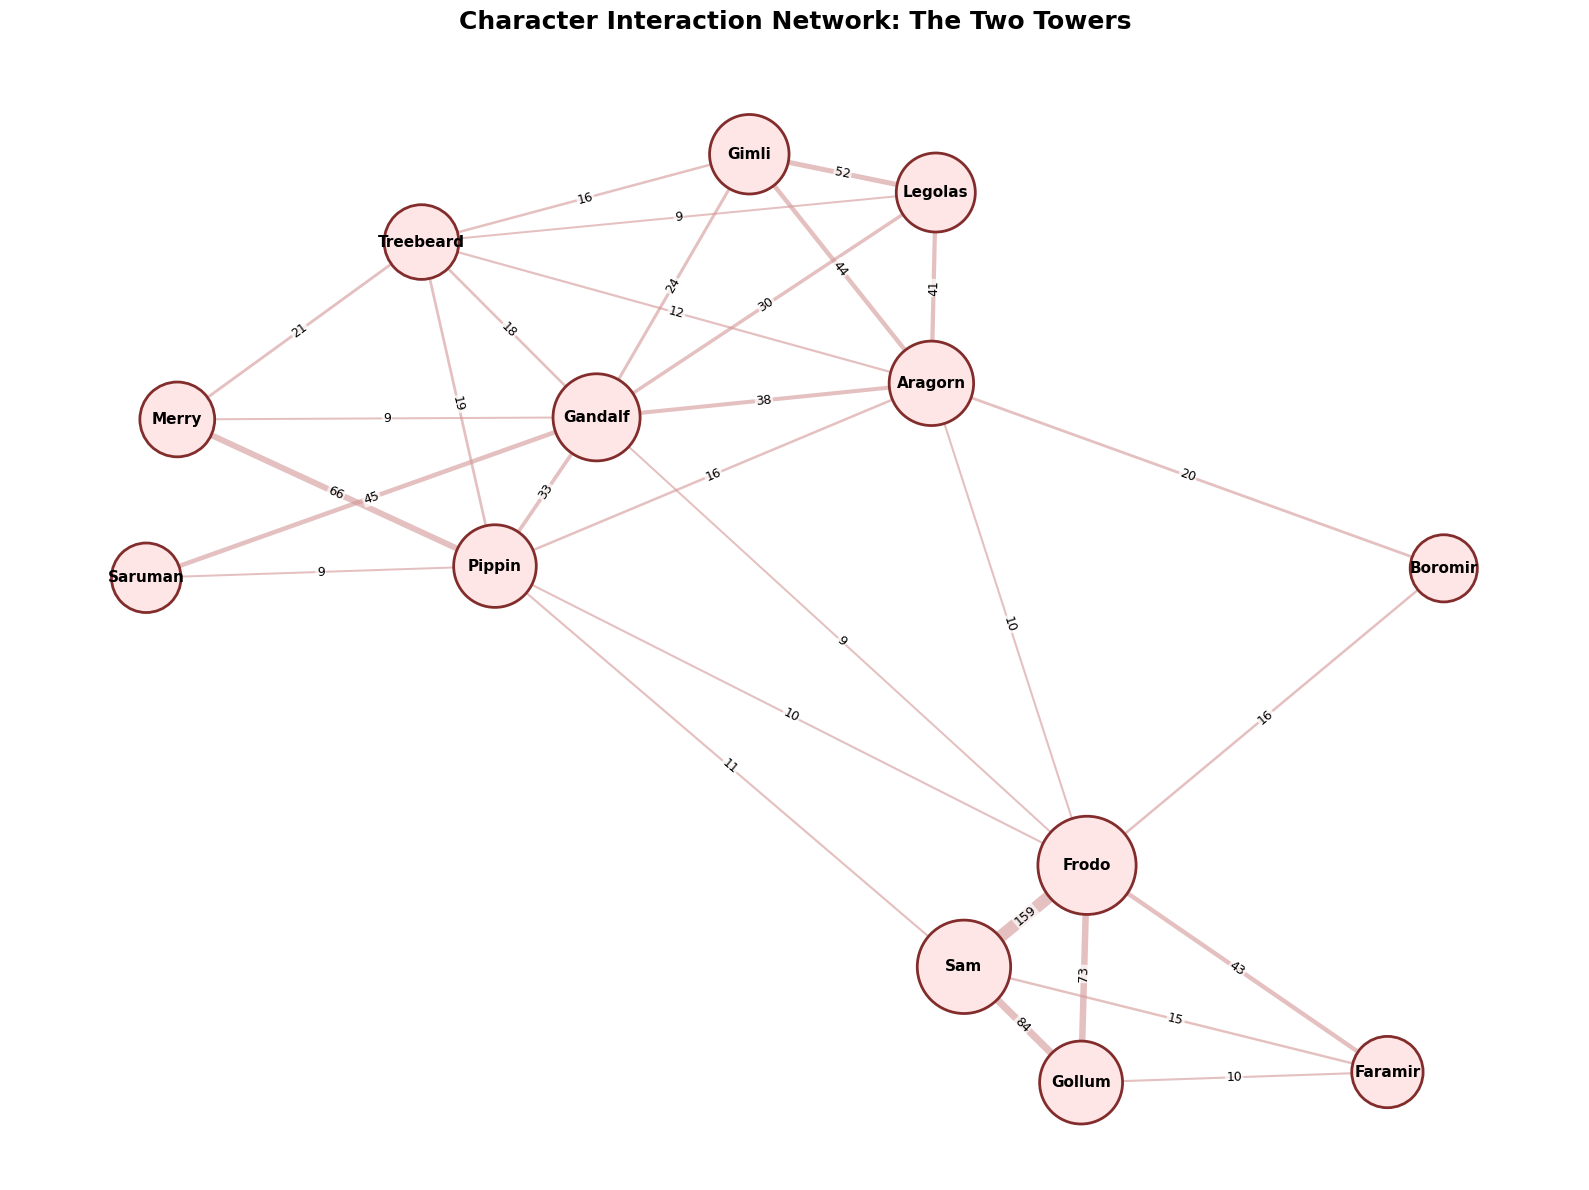

Processing The Return of the King...


In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import itertools
import numpy as np

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING (Same as before for consistency) ---
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"],
    "Arwen": ["arwen"],
    "Bilbo": ["bilbo"],
    "Tom Bombadil": ["tom", "bombadil"],
    "Treebeard": ["treebeard", "fangorn"],
    "Shelob": ["shelob"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- DATA LOADING AND PROCESSING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def extract_interactions(tokens, alias_map, window_size=15):
    """
    Scans tokens. If two characters appear within 'window_size' words of each other,
    it counts as an interaction.
    Returns an UNDIRECTED edge dictionary: {(CharA, CharB): count}
    where CharA < CharB alphabetically to ensure single edges.
    """
    edges = defaultdict(int)
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((i, alias_map[word]))
            
    # Check distances
    for i in range(len(char_positions)):
        pos1, char1 = char_positions[i]
        for j in range(i + 1, len(char_positions)):
            pos2, char2 = char_positions[j]
            
            if pos2 - pos1 > window_size:
                break # Optimization: sorted by position, so we can stop early
            
            if char1 != char2:
                # Sort names to ensure undirected edge key (A, B) == (B, A)
                u, v = sorted([char1, char2])
                edges[(u, v)] += 1
                
    return edges

def adjust_frodo_sam_position(pos, min_distance=0.25):
    """
    Specifically adjusts Frodo and Sam to prevent overlap.
    """
    if "Frodo" in pos and "Sam" in pos:
        x1, y1 = pos["Frodo"]
        x2, y2 = pos["Sam"]
        
        dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        if dist < min_distance and dist > 0:
            # Calculate direction vector
            dx = x2 - x1
            dy = y2 - y1
            
            # Normalize
            length = np.sqrt(dx**2 + dy**2)
            dx /= length
            dy /= length
            
            # Push them apart to achieve min_distance
            push = (min_distance - dist) / 2
            pos["Frodo"] = (x1 - dx * push, y1 - dy * push)
            pos["Sam"] = (x2 + dx * push, y2 + dy * push)
    
    return pos

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray',
                          fix_frodo_sam=False):
    """
    Generates an UNDIRECTED graph visualization.
    """
    
    # 1. Setup the Graph (Undirected)
    G = nx.Graph() 
    
    # 2. Filter Top Interactions
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)

    # 3. Calculate Visual Properties
    # Node Size based on degree (number of connections)
    d = dict(G.degree(weight='weight'))
    max_degree = max(d.values()) if d else 1
    # Increased base size for better visibility
    node_sizes = [2000 + (d[n] / max_degree * 3000) for n in G.nodes()]

    # Edge Width based on weight
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    widths = [1.0 + (w / max_weight * 8.0) for w in weights]

    # 4. Create the Plot
    plt.figure(figsize=(16, 12))
    
    # Layout - using k parameter to space out nodes
    pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)
    
    # Fix Frodo-Sam overlap if requested (for Return of the King)
    if fix_frodo_sam:
        pos = adjust_frodo_sam_position(pos, min_distance=0.25)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_color,
        edgecolors=border_color,
        linewidths=2
    )
    
    # Draw Edges (Straight lines for undirected)
    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_color,
        width=widths,
        alpha=0.6
    )
    
    # Draw Labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=11,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Weights)
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=9,
        label_pos=0.5,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.1')
    )

    plt.title(f"Character Interaction Network: {book_title}", 
              fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"], '#e6f3ff', '#2c5282', '#718096'),
        ("The Two Towers", CONFIG["book2_path"], '#ffe6e6', '#822c2c', '#d39797'),
        ("The Return of the King", CONFIG["book3_path"], '#e6ffe6', '#2c822c', '#97d397')
    ]

    print("Generating network graphs...")

    for title, path, n_color, b_color, e_color in books:
        print(f"Processing {title}...")
        tokens = clean_and_tokenize(path)
        
        if tokens:
            edges = extract_interactions(tokens, ALIAS_MAP)
            # Adjust top_n as needed for each book to control clutter
            if "Fellowship" in title:
                top_n = 39
            elif "Towers" in title:
                top_n = 30
            else:  # Return of the King
                top_n = 35  # Optimized for clarity and beauty
            
            # Apply Frodo-Sam fix only for Return of the King
            fix_frodo_sam = "King" in title
            
            plot_and_save_network(
                edges, 
                title, 
                f"network_{title.split()[1]}.png", 
                top_n=top_n,
                node_color=n_color, 
                border_color=b_color, 
                edge_color=e_color,
                fix_frodo_sam=fix_frodo_sam
            )
        else:
            print(f"Error: No tokens found for {title}")

Generating network graphs...
Processing The Fellowship of the Ring...


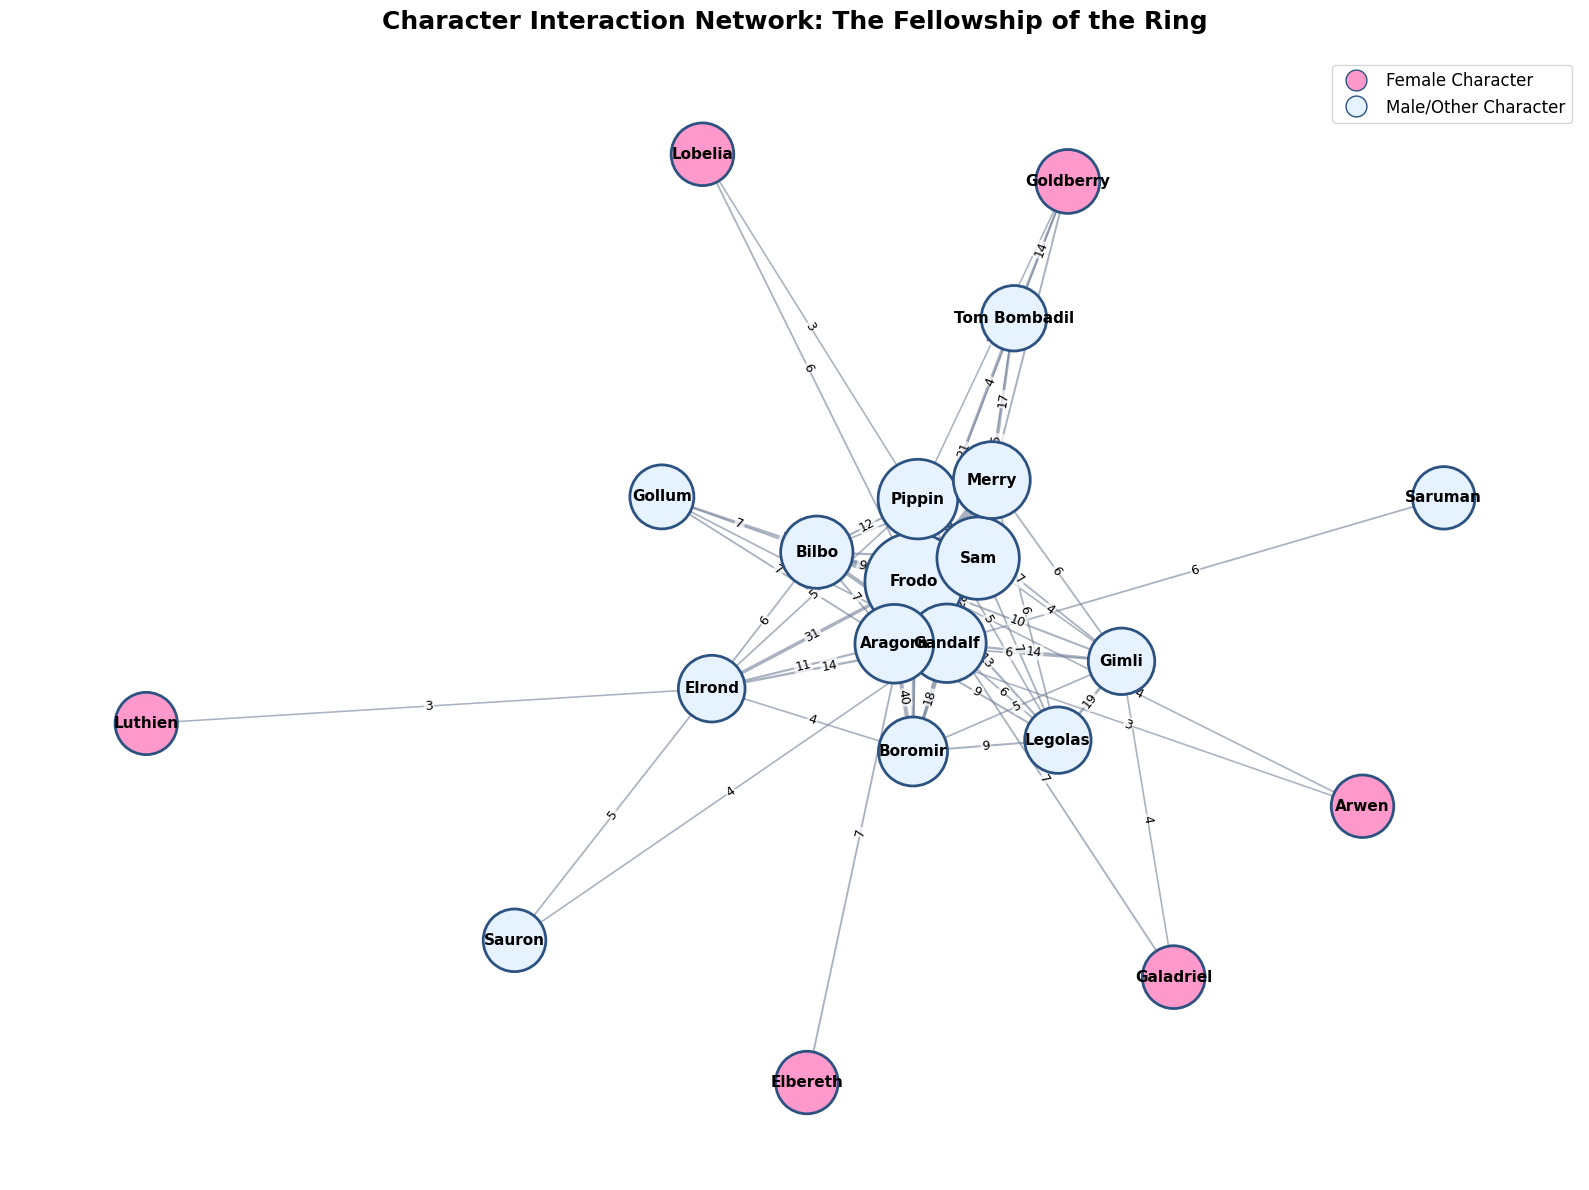

Processing The Two Towers...


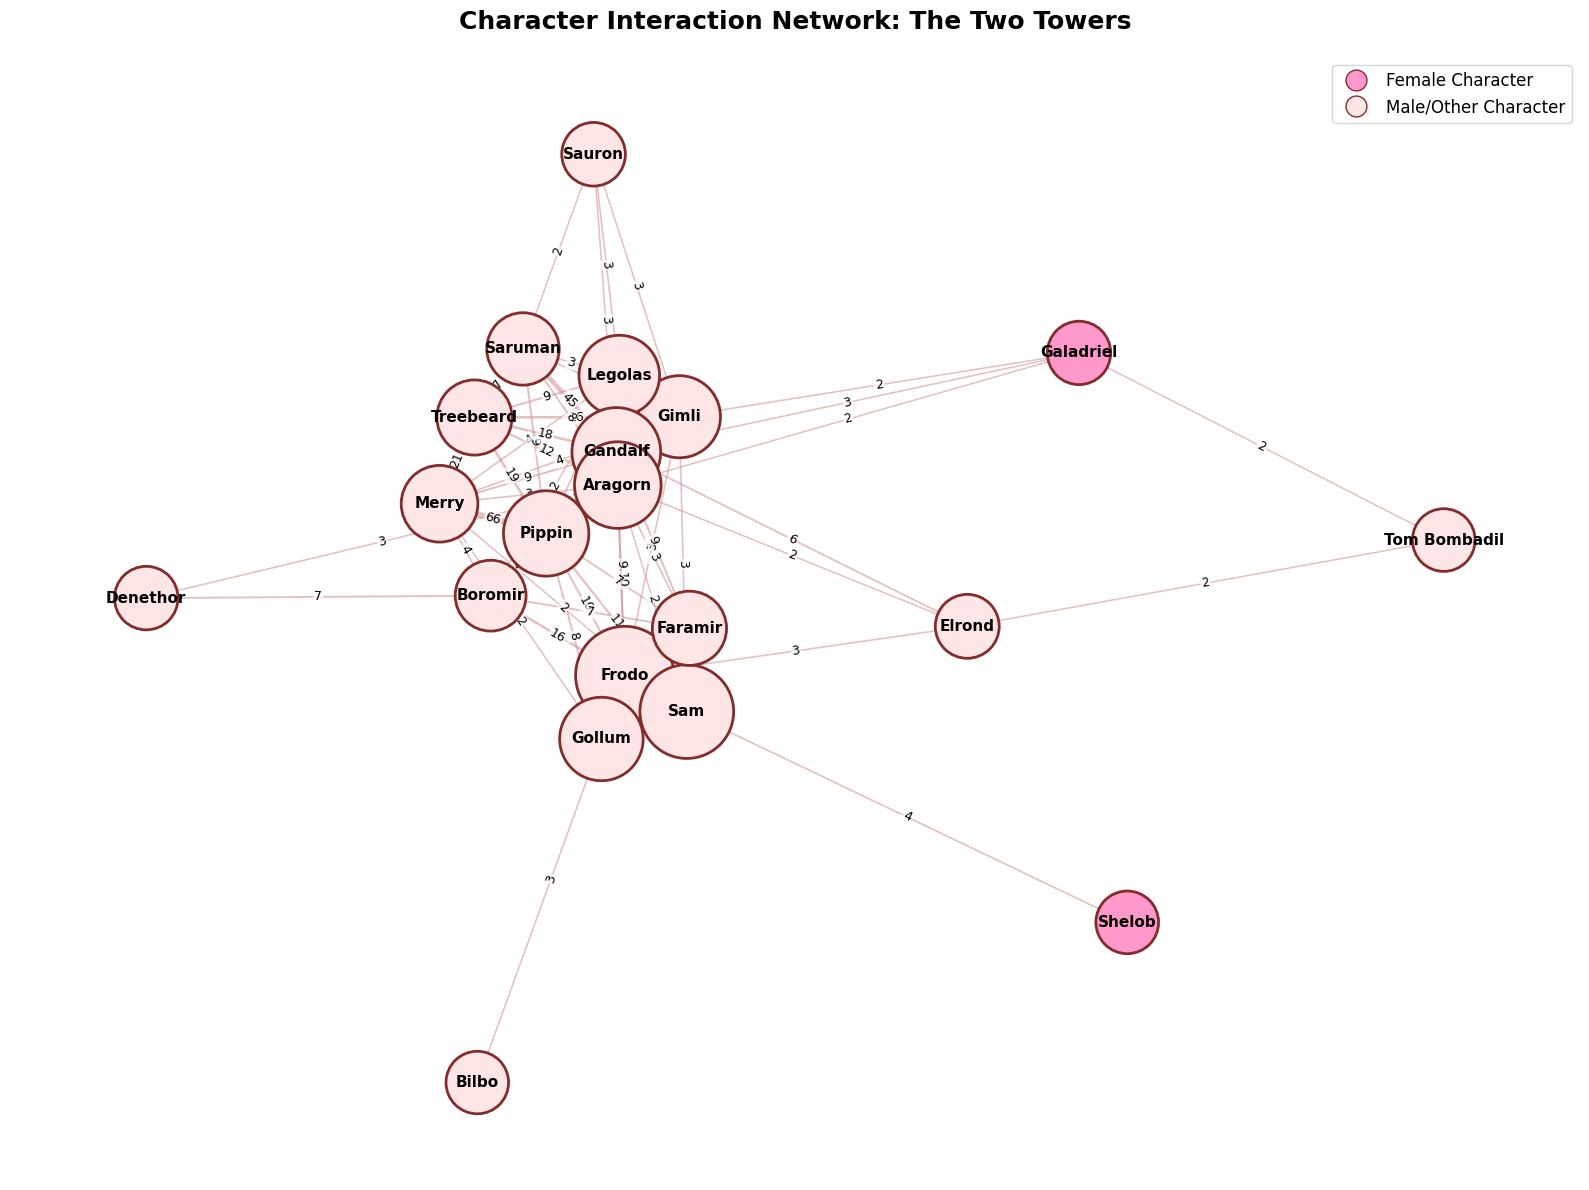

Processing The Return of the King...


In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import itertools

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel", "lady of light"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn", "dernhelm"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"],
    "Arwen": ["arwen", "evenstar"],
    "Bilbo": ["bilbo"],
    "Tom Bombadil": ["tom", "bombadil"],
    "Treebeard": ["treebeard", "fangorn"],
    "Shelob": ["shelob"],
    "Goldberry": ["goldberry"],
    "Rosie": ["rosie", "cotton"],
    "Ioreth": ["ioreth"],
    "Lobelia": ["lobelia"],
    "Primula": ["primula"],
    "Belladonna": ["belladonna"],
    "Gilraen": ["gilraen"],
    "Luthien": ["luthien"],
    "Elbereth": ["elbereth", "varda"]
}

# Identify Female Characters for highlighting
FEMALE_CHARACTERS = {
    "Galadriel", "Eowyn", "Arwen", "Shelob", "Goldberry", 
    "Rosie", "Ioreth", "Lobelia", "Primula", "Belladonna", 
    "Gilraen", "Luthien", "Elbereth"
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- DATA LOADING AND PROCESSING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def extract_interactions(tokens, alias_map, window_size=15):
    """
    Scans tokens. If two characters appear within 'window_size' words of each other,
    it counts as an interaction.
    Returns an UNDIRECTED edge dictionary: {(CharA, CharB): count}
    where CharA < CharB alphabetically to ensure single edges.
    """
    edges = defaultdict(int)
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((i, alias_map[word]))
            
    # Check distances
    for i in range(len(char_positions)):
        pos1, char1 = char_positions[i]
        for j in range(i + 1, len(char_positions)):
            pos2, char2 = char_positions[j]
            
            if pos2 - pos1 > window_size:
                break # Optimization: sorted by position, so we can stop early
            
            if char1 != char2:
                # Sort names to ensure undirected edge key (A, B) == (B, A)
                u, v = sorted([char1, char2])
                edges[(u, v)] += 1
                
    return edges

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          default_node_color='#e6f3ff', female_node_color='#FF69B4', 
                          border_color='#2c5282', edge_color='gray'):
    """
    Generates an UNDIRECTED graph visualization with female characters highlighted.
    """
    
    # 1. Setup the Graph (Undirected)
    G = nx.Graph() 
    
    # 2. Filter Top Interactions
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)

    # 3. Calculate Visual Properties
    # Node Size based on degree (number of connections)
    d = dict(G.degree(weight='weight'))
    max_degree = max(d.values()) if d else 1
    # Increased base size for better visibility
    node_sizes = [2000 + (d[n] / max_degree * 3000) for n in G.nodes()]

    # Assign Node Colors (Highlight Females)
    node_colors = []
    for node in G.nodes():
        if node in FEMALE_CHARACTERS:
            node_colors.append(female_node_color) # Highlight color for females
        else:
            node_colors.append(default_node_color) # Default color for others

    # Edge Width based on weight
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    widths = [1.0 + (w / max_weight * 8.0) for w in weights]

    # 4. Create the Plot
    plt.figure(figsize=(16, 12))
    
    # Layout - using k parameter to space out nodes
    pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors=border_color,
        linewidths=2
    )
    
    # Draw Edges (Straight lines for undirected)
    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_color,
        width=widths,
        alpha=0.6
    )
    
    # Draw Labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=11,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Weights)
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=9,
        label_pos=0.5,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.1')
    )

    # Add legend manually for Female vs Male
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Female Character',
                   markerfacecolor=female_node_color, markersize=15, markeredgecolor=border_color),
        plt.Line2D([0], [0], marker='o', color='w', label='Male/Other Character',
                   markerfacecolor=default_node_color, markersize=15, markeredgecolor=border_color)
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

    plt.title(f"Character Interaction Network: {book_title}", 
              fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"], '#e6f3ff', '#2c5282', '#718096'),
        ("The Two Towers", CONFIG["book2_path"], '#ffe6e6', '#822c2c', '#d39797'),
        ("The Return of the King", CONFIG["book3_path"], '#e6ffe6', '#2c822c', '#97d397')
    ]

    print("Generating network graphs...")

    for title, path, n_color, b_color, e_color in books:
        print(f"Processing {title}...")
        tokens = clean_and_tokenize(path)
        
        if tokens:
            edges = extract_interactions(tokens, ALIAS_MAP)
            # Adjust top_n as needed for each book to control clutter
            top_n = 70 # Increased slightly to ensure female characters are picked up if they have interactions
            
            plot_and_save_network(
                edges, 
                title, 
                f"network_{title.split()[1]}.png", 
                top_n=top_n,
                default_node_color=n_color, 
                female_node_color='#ff99cc', # distinct pink for female nodes
                border_color=b_color, 
                edge_color=e_color
            )
        else:
            print(f"Error: No tokens found for {title}")

Generating network graphs...
Processing The Fellowship of the Ring...


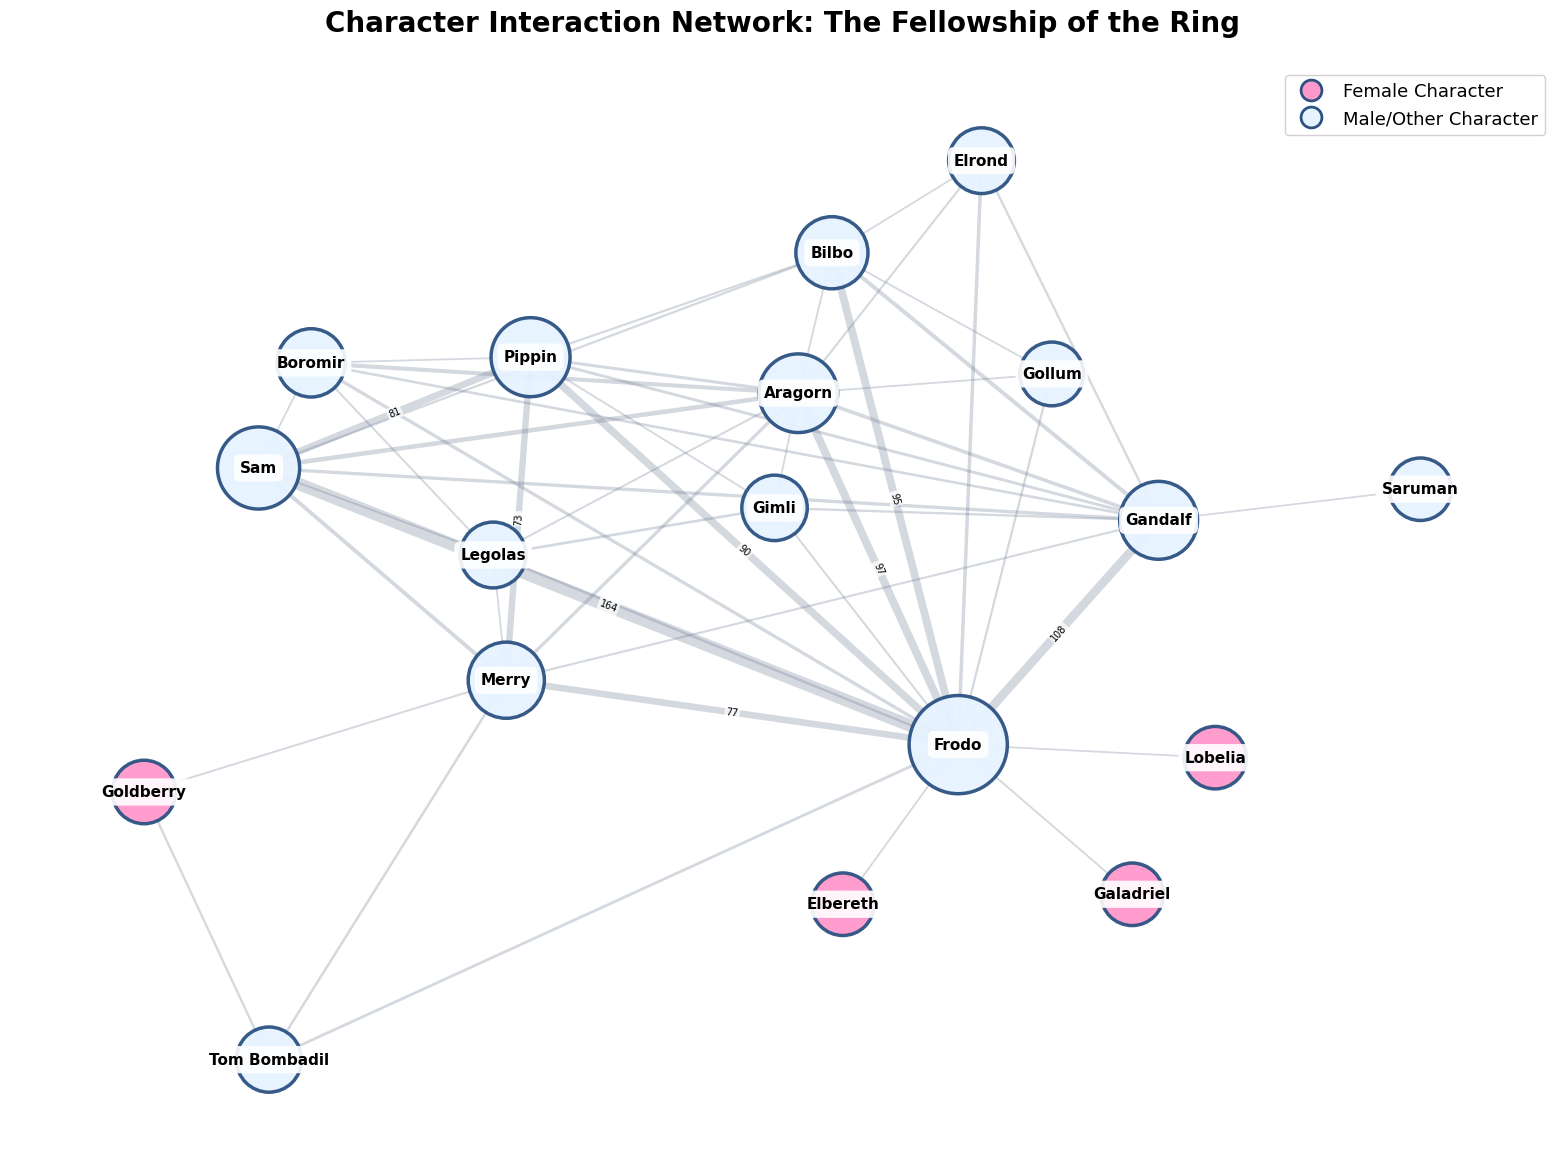

Saved: network_Fellowship.png
Processing The Two Towers...


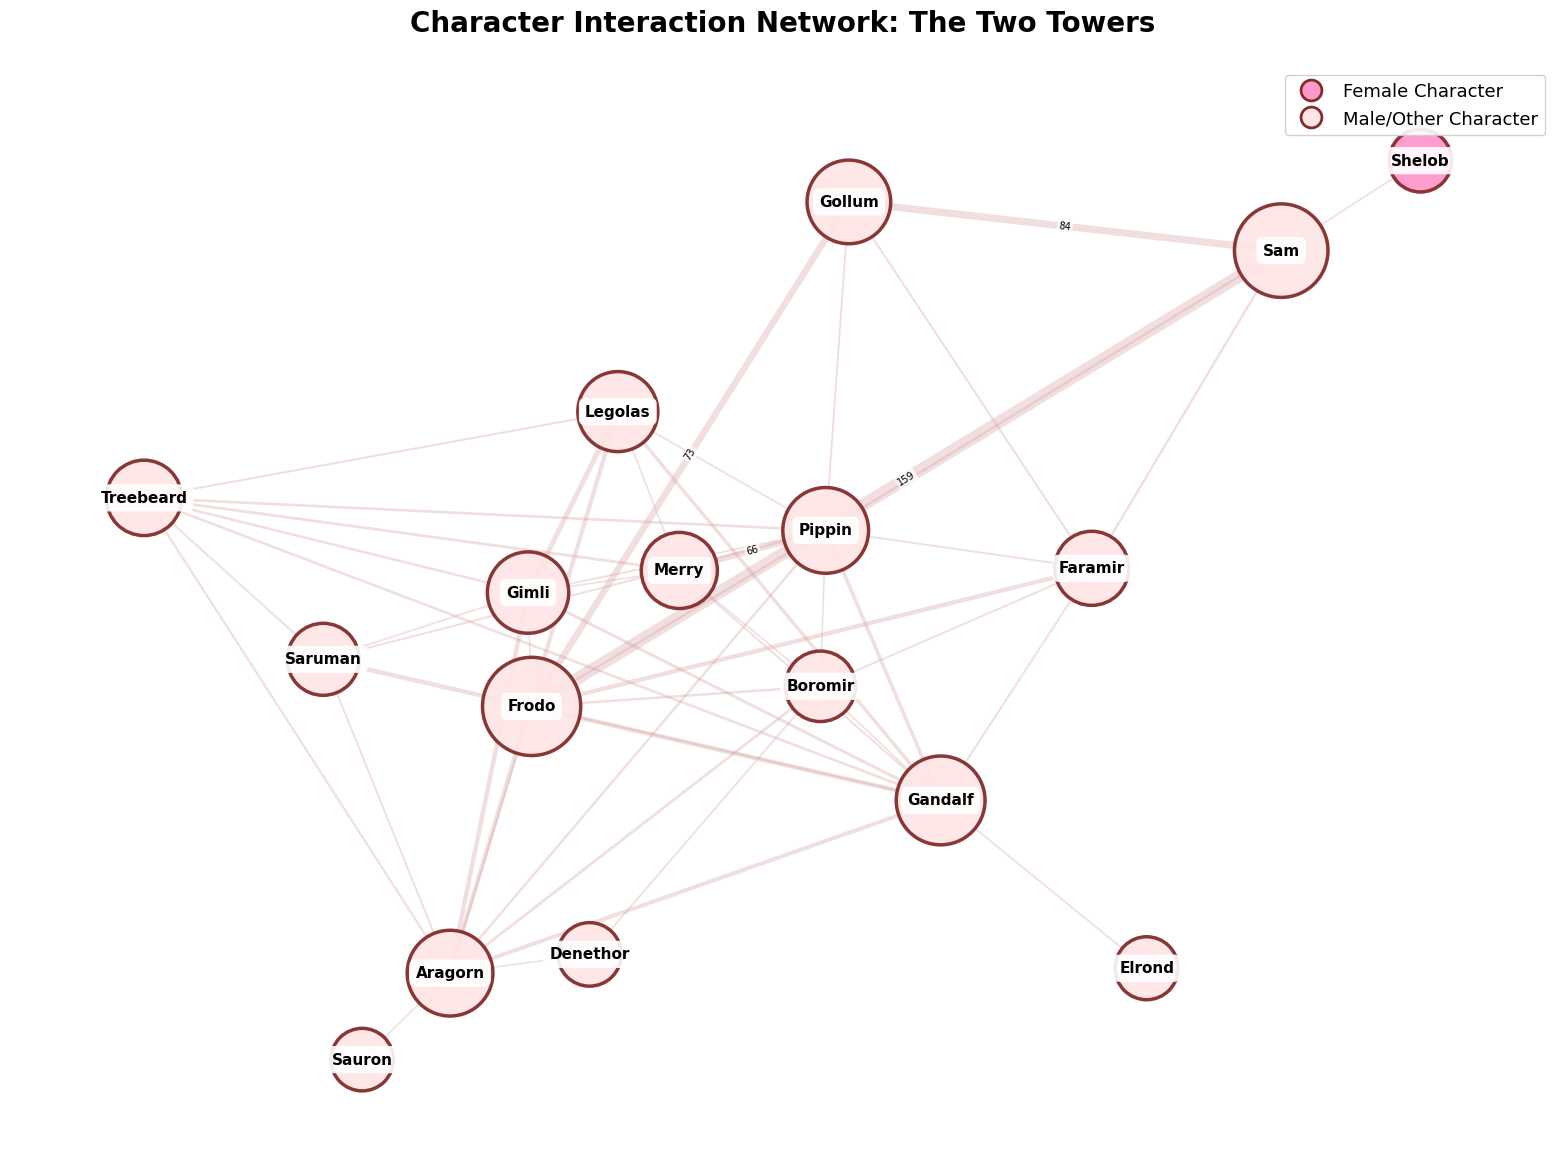

Saved: network_Two.png
Processing The Return of the King...


Saved: network_Return.png

All graphs generated successfully!


In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import itertools

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel", "lady of light"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn", "dernhelm"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"],
    "Arwen": ["arwen", "evenstar"],
    "Bilbo": ["bilbo"],
    "Tom Bombadil": ["tom", "bombadil"],
    "Treebeard": ["treebeard", "fangorn"],
    "Shelob": ["shelob"],
    "Goldberry": ["goldberry"],
    "Rosie": ["rosie", "cotton"],
    "Ioreth": ["ioreth"],
    "Lobelia": ["lobelia"],
    "Primula": ["primula"],
    "Belladonna": ["belladonna"],
    "Gilraen": ["gilraen"],
    "Luthien": ["luthien"],
    "Elbereth": ["elbereth", "varda"]
}

# Identify Female Characters for highlighting
FEMALE_CHARACTERS = {
    "Galadriel", "Eowyn", "Arwen", "Shelob", "Goldberry", 
    "Rosie", "Ioreth", "Lobelia", "Primula", "Belladonna", 
    "Gilraen", "Luthien", "Elbereth"
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- DATA LOADING AND PROCESSING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def extract_interactions(tokens, alias_map, window_size=15):
    """
    Scans tokens. If two characters appear within 'window_size' words of each other,
    it counts as an interaction.
    Returns an UNDIRECTED edge dictionary: {(CharA, CharB): count}
    where CharA < CharB alphabetically to ensure single edges.
    """
    edges = defaultdict(int)
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((i, alias_map[word]))
            
    # Check distances
    for i in range(len(char_positions)):
        pos1, char1 = char_positions[i]
        for j in range(i + 1, len(char_positions)):
            pos2, char2 = char_positions[j]
            
            if pos2 - pos1 > window_size:
                break # Optimization: sorted by position, so we can stop early
            
            if char1 != char2:
                # Sort names to ensure undirected edge key (A, B) == (B, A)
                u, v = sorted([char1, char2])
                edges[(u, v)] += 1
                
    return edges

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          default_node_color='#e6f3ff', female_node_color='#FF69B4', 
                          border_color='#2c5282', edge_color='gray'):
    """
    Generates an UNDIRECTED graph visualization with female characters highlighted.
    Fixed version with better node spacing and no overlaps.
    """
    
    # 1. Setup the Graph (Undirected)
    G = nx.Graph() 
    
    # 2. Filter Top Interactions
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)

    # 3. Calculate Visual Properties
    # Node Size based on degree (number of connections) - keeping original size range
    d = dict(G.degree(weight='weight'))
    max_degree = max(d.values()) if d else 1
    node_sizes = [2000 + (d[n] / max_degree * 3000) for n in G.nodes()]

    # Assign Node Colors (Highlight Females)
    node_colors = []
    for node in G.nodes():
        if node in FEMALE_CHARACTERS:
            node_colors.append(female_node_color)
        else:
            node_colors.append(default_node_color)

    # Edge Width based on weight - keeping original thickness
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    widths = [1.0 + (w / max_weight * 8.0) for w in weights]

    # 4. Create the Plot - keeping original size
    plt.figure(figsize=(16, 12))
    
    # FIXED: Use multiple layout attempts to find best non-overlapping configuration
    # Try Kamada-Kawai first with high scale for maximum spacing
    best_pos = None
    min_overlap_score = float('inf')
    
    # Try multiple layout algorithms and pick the best one
    layout_attempts = [
        ('kamada_kawai', lambda: nx.kamada_kawai_layout(G, scale=5)),
        ('spring_k6', lambda: nx.spring_layout(G, k=6.0, iterations=300, seed=42)),
        ('spring_k7', lambda: nx.spring_layout(G, k=7.0, iterations=300, seed=123)),
    ]
    
    for name, layout_func in layout_attempts:
        try:
            test_pos = layout_func()
            # Calculate simple overlap score (sum of distances between nodes)
            total_dist = 0
            nodes_list = list(test_pos.keys())
            for i in range(len(nodes_list)):
                for j in range(i+1, len(nodes_list)):
                    n1, n2 = nodes_list[i], nodes_list[j]
                    dist = ((test_pos[n1][0] - test_pos[n2][0])**2 + 
                           (test_pos[n1][1] - test_pos[n2][1])**2)**0.5
                    total_dist += 1/dist if dist > 0 else 1000  # Penalize close nodes
            
            if total_dist < min_overlap_score:
                min_overlap_score = total_dist
                best_pos = test_pos
        except:
            continue
    
    # Fallback if all fail
    if best_pos is None:
        best_pos = nx.spring_layout(G, k=5.0, iterations=250, seed=42)
    
    pos = best_pos
    
    # Draw Edges first (so they appear behind nodes)
    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_color,
        width=widths,
        alpha=0.3  # More transparent to reduce visual clutter
    )
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors=border_color,
        linewidths=2.5,
        alpha=0.95
    )
    
    # Draw Labels with background boxes to prevent overlap with edges
    for node, (x, y) in pos.items():
        plt.text(x, y, node,
                fontsize=11,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(boxstyle='round,pad=0.4', 
                         facecolor='white', 
                         edgecolor='none', 
                         alpha=0.9))
    
    # Draw Edge Labels only for strongest connections to reduce clutter
    strong_edges = {(u, v): d['weight'] for u, v, d in G.edges(data=True) 
                   if d['weight'] > max_weight * 0.4}  # Only show top 40% of edge weights
    
    if strong_edges:
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=strong_edges,
            font_size=7,
            label_pos=0.5,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.75, boxstyle='round,pad=0.15')
        )

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Female Character',
                   markerfacecolor=female_node_color, markersize=15, markeredgecolor=border_color, markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', label='Male/Other Character',
                   markerfacecolor=default_node_color, markersize=15, markeredgecolor=border_color, markeredgewidth=2)
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=13, framealpha=0.9)

    plt.title(f"Character Interaction Network: {book_title}", 
              fontsize=20, fontweight='bold', pad=25)
    plt.axis('off')
    plt.tight_layout(pad=2)
    
    # Save with high DPI for clarity
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Saved: {filename}")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"], '#e6f3ff', '#2c5282', '#718096'),
        ("The Two Towers", CONFIG["book2_path"], '#ffe6e6', '#822c2c', '#d39797'),
        ("The Return of the King", CONFIG["book3_path"], '#e6ffe6', '#2c822c', '#97d397')
    ]

    print("Generating network graphs...")

    for title, path, n_color, b_color, e_color in books:
        print(f"Processing {title}...")
        tokens = clean_and_tokenize(path)
        
        if tokens:
            edges = extract_interactions(tokens, ALIAS_MAP)
            # Adjust top_n based on book complexity
            top_n = 50  # Balanced to show important connections without clutter
            
            plot_and_save_network(
                edges, 
                title, 
                f"network_{title.split()[1]}.png", 
                top_n=top_n,
                default_node_color=n_color, 
                female_node_color='#ff99cc',
                border_color=b_color, 
                edge_color=e_color
            )
        else:
            print(f"Error: No tokens found for {title}")
    
    print("\nAll graphs generated successfully!")